# MVDR NumPy vs PyTorch Implementation Comparison

This notebook compares a NumPy-based MVDR implementation (`mvdr.py`, `util.py`)
with a PyTorch-based implementation (`mvdr_torch.py`, `util_torch.py`).

**Comparison Steps:**
1.  Setup parameters (sampling rate, array config, FFT settings).
2.  Generate identical mono source audio (clean and noisy).
3.  Generate identical multi-channel audio using one method (e.g., NumPy version).
4.  Initialize both NumPy and PyTorch MVDR beamformers.
5.  For a target angle:
    * Calculate Steering Vectors and compare.
    * Calculate Spatial Correlation Matrices (SCM) and compare.
    * Calculate MVDR Weights and compare.
    * Apply beamformers to the multi-channel audio.
6.  Compare the output waveforms:
    * Calculate Root Mean Squared Error (RMSE).
    * Calculate the Power Ratio of the difference signal.
7.  Visualize results:
    * Spectrograms (Input, Outputs, Difference).
    * Waveforms (Input, Outputs, Difference).
    * Directional Response (Beampattern) for both sets of weights across specified angles.
8.  Timing Comparison:
    * Measure execution time for key operations in both implementations.
    * Compare performance across different look directions.


## 1. Setup

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal as sg
import os
import sys
from typing import Tuple, Dict, Optional, List
import librosa.display
import time

# Import user-provided modules
from beamform import util
from beamform import mvdr
from beamform import util_torch
from beamform import mvdr_torch
import audio_generation
import audio_generation_torch


In [2]:
# Configure Matplotlib for inline display
# %matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True


In [3]:
print(f"NumPy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")


NumPy version: 1.26.4
PyTorch version: 2.2.2


### Parameters

In [4]:
# Audio Parameters
TEST_FREQUENCY = 1000  # Frequency of the desired source signal (Hz)
DURATION = 1.0  # Audio duration (seconds)
SAMPLING_FREQUENCY = 16000  # Sampling frequency (Hz)

# Array Parameters
NUM_MICS = 8      # Number of microphones
MIC_SPACING = 0.04    # Microphone separation (meters) for ULA
SOUND_SPEED = 343.0 # Speed of sound (m/s)

# STFT Parameters
FFT_LENGTH = 512         # FFT length for STFT
FFT_SHIFT = 256 # Hop size (50% overlap)
FRAME_LENGTH = FFT_LENGTH      # Window length (using same as FFT length)

# MVDR Parameters
LOOK_DIRECTION_DEG = 0 # Target angle for beamforming (degrees, 0=broadside)
SCM_INIT_FRAMES = 10 # Number of initial frames for SCM calculation
SCM_FINAL_FRAMES = 10 # Number of final frames for SCM calculation
STABILIZATION_THETA = 1e5     # Stabilization threshold for SCM inversion

# Comparison Parameters
NUM_ANGLES_TO_TEST = 500 # Number of points for polar analysis
MIN_ANGLE_DEG = -90 # Minimum angle for directional plot evaluation
MAX_ANGLE_DEG = 90 # Maximum angle for directional plot evaluation
PLOT_ANGLES_DEG = np.linspace(MIN_ANGLE_DEG, MAX_ANGLE_DEG, NUM_ANGLES_TO_TEST) # Angles for polar analysis
DB_THRESHOLD = -50      # Minimum dB value for plotting
PLOT_TITLE_SUFFIX = "" # Optional suffix for plot titles
FREQ_BIN_FOR_SCM_PLOT = int(TEST_FREQUENCY * FFT_LENGTH / SAMPLING_FREQUENCY) # Bin for SCM visualization

# Angles to test (as per requirements)
TEST_ANGLES = [-30, -18, -6, 0, 6, 18, 30]

print("Using parameters:")
for name, value in locals().copy().items():
    if name.isupper() and not name.startswith('_'):
        print(f"- {name}: {value}")

Using parameters:
- TEST_FREQUENCY: 1000
- DURATION: 1.0
- SAMPLING_FREQUENCY: 16000
- NUM_MICS: 8
- MIC_SPACING: 0.04
- SOUND_SPEED: 343.0
- FFT_LENGTH: 512
- FFT_SHIFT: 256
- FRAME_LENGTH: 512
- LOOK_DIRECTION_DEG: 0
- SCM_INIT_FRAMES: 10
- SCM_FINAL_FRAMES: 10
- STABILIZATION_THETA: 100000.0
- NUM_ANGLES_TO_TEST: 500
- MIN_ANGLE_DEG: -90
- MAX_ANGLE_DEG: 90
- PLOT_ANGLES_DEG: [-90.         -89.63927856 -89.27855711 -88.91783567 -88.55711423
 -88.19639279 -87.83567134 -87.4749499  -87.11422846 -86.75350701
 -86.39278557 -86.03206413 -85.67134269 -85.31062124 -84.9498998
 -84.58917836 -84.22845691 -83.86773547 -83.50701403 -83.14629259
 -82.78557114 -82.4248497  -82.06412826 -81.70340681 -81.34268537
 -80.98196393 -80.62124248 -80.26052104 -79.8997996  -79.53907816
 -79.17835671 -78.81763527 -78.45691383 -78.09619238 -77.73547094
 -77.3747495  -77.01402806 -76.65330661 -76.29258517 -75.93186373
 -75.57114228 -75.21042084 -74.8496994  -74.48897796 -74.12825651
 -73.76753507 -73.4068136

In [5]:
# PyTorch Device
DEVICE = util_torch.get_device() # Automatically selects CUDA if available, else CPU
print(f"Using PyTorch device: {DEVICE}")
# Uncomment to override device selection
# DEVICE = torch.device('cpu')
# print(f"Overriding PyTorch device to: {DEVICE}")


Using PyTorch device: cpu


In [6]:
# Output Directory
OUTPUT_DIR = "comparison_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Helper Functions

In [7]:
def calculate_rmse(signal1: np.ndarray, signal2: np.ndarray) -> float:
    """Calculates the Root Mean Squared Error between two signals."""
    return np.sqrt(np.mean((signal1 - signal2)**2))

def calculate_power_ratio_db(signal: np.ndarray, noise: np.ndarray, eps=1e-10) -> float:
    """Calculates the power ratio (like SNR) in dB."""
    power_signal = np.mean(signal**2)
    power_noise = np.mean(noise**2)
    ratio = 10 * np.log10(power_signal / (power_noise + eps))
    return ratio

def compare_complex_arrays(arr1: np.ndarray, arr2: np.ndarray, name: str, tol=1e-5) -> Dict:
    """Compares two complex numpy arrays."""
    diff = arr1 - arr2
    max_abs_diff = np.max(np.abs(diff))
    is_close = np.allclose(arr1, arr2, atol=tol)
    print(f"Comparing {name}:")
    print(f"  Shapes: {arr1.shape} vs {arr2.shape}")
    print(f"  Max absolute difference: {max_abs_diff:.2e}")
    print(f"  Arrays are close (atol={tol}): {is_close}")
    return {"max_abs_diff": max_abs_diff, "is_close": is_close}

def plot_spectrogram(ax, audio, fs, fft_len, fft_shift, title):
    """Plots a spectrogram."""
    spec, freqs, t, im = ax.specgram(audio, NFFT=fft_len, Fs=fs, noverlap=fft_shift, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    # Add colorbar? Maybe later for clarity.

def plot_waveform(ax, audio, fs, title):
    """Plots a time-domain waveform."""
    time = np.arange(len(audio)) / fs
    ax.plot(time, audio)
    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_ylim(np.min(audio) * 1.1, np.max(audio) * 1.1)

def plot_beampattern(ax, weights, mic_positions, target_freq_hz, fs, sound_speed, plot_angles_deg, fft_len, fft_shift, title):
    """Plots the directional beampattern for given weights at a target frequency."""
    num_mics = weights.shape[0]
    num_bins = weights.shape[1]
    target_bin = int(np.round(target_freq_hz * fft_len / fs))
    if target_bin >= num_bins:
        target_bin = num_bins - 1
        print(f"Warning: Target frequency {target_freq_hz}Hz maps to bin {target_bin}, using max bin.")

    freq_vector = torch.linspace(0, fs / 2, num_bins, device=DEVICE) # Use torch for consistency if possible

    responses = []
    # Use NumPy mic positions for steering vector calculation as MVDR classes expect NumPy array for source pos
    mic_positions_np = mic_positions.cpu().numpy() if isinstance(mic_positions, torch.Tensor) else mic_positions

    weights_f = weights[:, target_bin] # Weights for the target frequency bin

    for angle_deg in plot_angles_deg:
        # Calculate steering vector for this angle and frequency
        # Need a dummy source position far away at this angle
        r_far = 100.0 # Assume far field
        angle_rad_map = np.radians(90 - angle_deg) # Angle for calculatePos3d convention
        s_test = np.array([[r_far * np.cos(angle_rad_map)], [r_far * np.sin(angle_rad_map)], [0.0]])

        # Re-calculate steering vector using the same method as MVDR classes
        # Using NumPy MVDR's method for simplicity here, assuming PyTorch one is similar
        # Need temporary MVDR instance just for steering vector calculation method
        temp_mvdr_np = mvdr.MinimumVarianceDistortionlessResponse(mic_positions_np, fs, sound_speed, fft_len, fft_shift)
        steering_vector_angle = temp_mvdr_np.get_steering_vector(s_test) # [M, num_bins]

        # Get steering vector for the specific frequency bin
        d_f_angle = steering_vector_angle[:, target_bin] # [M]

        # Calculate response: | w^H * d |
        response = np.abs(np.vdot(weights_f, d_f_angle)) # vdot computes w_conj.T @ d
        responses.append(response)

    responses_db = 20 * np.log10(np.array(responses) + 1e-8) # Convert to dB, add epsilon
    responses_db = responses_db - np.max(responses_db) # Normalize to 0 dB max

    ax.plot(plot_angles_deg, responses_db)
    ax.set_title(f"{title} (Freq ≈ {target_freq_hz} Hz)")
    ax.set_xlabel("Angle (degrees)")
    ax.set_ylabel("Response (dB)")
    ax.set_ylim([-40, 5]) # Typical dB range for beampatterns
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90]) # Simplified ticks for readability
    
def plot_polar_beampattern(weights, mic_positions, target_freq_hz, fs, sound_speed, plot_angles_deg, fft_len, fft_shift, title):
    """Plots a polar beampattern based on weights."""
    num_mics = weights.shape[0]
    num_bins = weights.shape[1]
    target_bin = int(np.round(target_freq_hz * fft_len / fs))
    if target_bin >= num_bins:
        target_bin = num_bins - 1
        print(f"Warning: Target frequency {target_freq_hz}Hz maps to bin {target_bin}, using max bin.")

    freq_vector = torch.linspace(0, fs / 2, num_bins, device=DEVICE) # Use torch for consistency

    responses = []
    angles_rad = []
    # Use NumPy mic positions for steering vector calculation
    mic_positions_np = mic_positions.cpu().numpy() if isinstance(mic_positions, torch.Tensor) else mic_positions

    weights_f = weights[:, target_bin] # Weights for the target frequency bin
    temp_mvdr_np = mvdr.MinimumVarianceDistortionlessResponse(mic_positions_np, fs, sound_speed, fft_len, fft_shift)
    
    for angle_deg in plot_angles_deg:
        # Convert to radians for polar plot
        angle_rad = np.radians(angle_deg)
        angles_rad.append(angle_rad)
        
        # Calculate steering vector
        angle_rad_map = np.radians(90 - angle_deg) # Angle for calculatePos3d convention
        s_test = np.array([[100.0 * np.cos(angle_rad_map)], [100.0 * np.sin(angle_rad_map)], [0.0]])
        steering_vector_angle = temp_mvdr_np.get_steering_vector(s_test) # [M, num_bins]
        d_f_angle = steering_vector_angle[:, target_bin] # [M]
        
        # Calculate response: | w^H * d |
        response = np.abs(np.vdot(weights_f, d_f_angle))
        responses.append(response)

    # Convert to dB and normalize
    responses_db = 20 * np.log10(np.array(responses) + 1e-8)
    responses_db = responses_db - np.max(responses_db) # Normalize to 0 dB max
    
    # Ensure minimum threshold
    responses_db = np.maximum(responses_db, DB_THRESHOLD)

    # Create polar plot
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')
    ax.plot(angles_rad, responses_db)
    
    # Customize the polar plot
    ax.set_theta_zero_location('N')  # Set 0 degrees to the top (North)
    ax.set_theta_direction(-1)       # Set angles to increase clockwise
    ax.set_thetamin(MIN_ANGLE_DEG)
    ax.set_thetamax(MAX_ANGLE_DEG)
    
    # Set radial limits (dB scale)
    ax.set_rlim([DB_THRESHOLD, 5])
    ax.set_rticks(np.arange(DB_THRESHOLD, 1, 10))
    
    plt.title(f'{title} (Freq ≈ {target_freq_hz} Hz)')
    plt.tight_layout()
    return fig
    
# Timer decorator for measuring execution time of functions
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"{func.__name__} executed in: {execution_time:.4f} seconds")
        return result, execution_time
    return wrapper


## 2. Microphone Array Setup

In [8]:
def setup_array_geometry(num_mics, mic_spacing, look_direction_deg):
    """Sets up the microphone array geometry and the source position for the look direction."""
    # Using ULA centered at origin along x-axis
    mic_positions_np = np.zeros((3, num_mics))
    mic_positions_np[0, :] = np.linspace(-(num_mics - 1) * mic_spacing / 2, (num_mics - 1) * mic_spacing / 2, num_mics)
    mic_positions_torch = torch.from_numpy(mic_positions_np).float().to(DEVICE)

    print("Microphone Positions (m):")
    print(mic_positions_np)

    # Calculate source position for the target angle (used for steering vector calculation)
    target_angle_rad_map = np.radians(90 - look_direction_deg) # For calculatePos3d convention
    r_source = 10.0 # Assumed source distance (doesn't impact steering vec direction)
    source_position_s = np.array([[r_source * np.cos(target_angle_rad_map)],
                                  [r_source * np.sin(target_angle_rad_map)],
                                  [0.0]])
    print(f"\nTarget Source Position for Angle {look_direction_deg}° (example distance):")
    print(source_position_s)
    
    return mic_positions_np, mic_positions_torch, source_position_s

# Setup initial array for demonstration
mic_positions_np, mic_positions_torch, source_position_s = setup_array_geometry(
    NUM_MICS, MIC_SPACING, LOOK_DIRECTION_DEG)

Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

Target Source Position for Angle 0° (example distance):
[[6.123234e-16]
 [1.000000e+01]
 [0.000000e+00]]


## 3. Audio Generation

In [9]:
@timing_decorator
def generate_audio_signals(freq_hz, duration, fs, target_angle_deg, num_mics, mic_spacing, sound_speed):
    """Generates mono and multi-channel audio signals."""
    # Generate mono signals
    mono_clean = audio_generation.make_mono_audio(freq_hz, duration, fs, write_file=False)
    
    # Generate multi-channel signal from the target direction
    multi_channel_clean_np = audio_generation.delay_across_channels_py_freq(
        mono_audio=mono_clean,
        steering_angle_deg=target_angle_deg,
        num_mics=num_mics,
        mic_separation=mic_spacing,
        fs=fs,
        speed_of_sound=sound_speed
    ) # Shape: [num_samples, num_mics]
    
    # Convert to PyTorch tensor format [channels, samples]
    multi_channel_clean_pt_tensor = torch.from_numpy(multi_channel_clean_np.T).float().to(DEVICE)
    
    print(f"Generated signals: mono ({len(mono_clean)} samples), "
          f"multi-channel {multi_channel_clean_np.shape}, "
          f"tensor {multi_channel_clean_pt_tensor.shape}")
    
    return mono_clean, multi_channel_clean_np, multi_channel_clean_pt_tensor

# Generate audio for demonstration
(mono_clean, multi_channel_clean_np, multi_channel_clean_pt_tensor), audio_gen_time = generate_audio_signals(
    TEST_FREQUENCY, DURATION, SAMPLING_FREQUENCY, 
    LOOK_DIRECTION_DEG, NUM_MICS, MIC_SPACING, SOUND_SPEED)

Generated signals: mono (16000 samples), multi-channel (16000, 8), tensor torch.Size([8, 16000])
generate_audio_signals executed in: 0.0108 seconds


## 4. Initialize MVDR Beamformers

In [10]:
@timing_decorator
def initialize_beamformers(mic_positions_np, sampling_frequency, sound_speed, fft_length, fft_shift, device):
    """Initialize both NumPy and PyTorch MVDR beamformers."""
    # NumPy MVDR
    mvdr_np = mvdr.MinimumVarianceDistortionlessResponse(
        mic_positions_m=mic_positions_np,
        sampling_frequency=sampling_frequency,
        sound_speed=sound_speed,
        fft_length=fft_length,
        fft_shift=fft_shift
    )
    
    # PyTorch MVDR
    mvdr_pt = mvdr_torch.MinimumVarianceDistortionlessResponseTorch(
        mic_positions_m=mic_positions_np, # Pass NumPy array, it converts internally
        sampling_frequency=sampling_frequency,
        sound_speed=sound_speed,
        fft_length=fft_length,
        fft_shift=fft_shift,
        device=device
    )
    
    return mvdr_np, mvdr_pt

# Initialize beamformers for demonstration
(mvdr_np, mvdr_pt), init_time = initialize_beamformers(
    mic_positions_np, SAMPLING_FREQUENCY, SOUND_SPEED, FFT_LENGTH, FFT_SHIFT, DEVICE)

print("NumPy and PyTorch MVDR beamformers initialized.")

initialize_beamformers executed in: 0.0044 seconds
NumPy and PyTorch MVDR beamformers initialized.


## 5. Define the Processing Function for a Given Look Direction

In [11]:
def process_for_look_direction(look_direction_deg, save_plots=True):
    """Process audio and run comparison for a specific look direction."""
    print(f"\n{'-'*50}\nProcessing for look direction: {look_direction_deg}°\n{'-'*50}")
    
    # Setup array geometry for this look direction
    mic_pos_np, mic_pos_torch, source_pos_s = setup_array_geometry(
        NUM_MICS, MIC_SPACING, look_direction_deg)
    
    # Generate test audio for this look direction
    (mono_sig, multi_channel_np, multi_channel_pt), _ = generate_audio_signals(
        TEST_FREQUENCY, DURATION, SAMPLING_FREQUENCY, 
        look_direction_deg, NUM_MICS, MIC_SPACING, SOUND_SPEED)
    
    # Initialize beamformers
    (mvdr_np_beamformer, mvdr_pt_beamformer), _ = initialize_beamformers(
        mic_pos_np, SAMPLING_FREQUENCY, SOUND_SPEED, FFT_LENGTH, FFT_SHIFT, DEVICE)
    
    # Timing dictionary to store execution times
    timing_results = {
        'numpy': {'steering_vector': 0, 'scm': 0, 'weights': 0, 'stft': 0, 'apply': 0, 'istft': 0, 'total': 0},
        'pytorch': {'steering_vector': 0, 'scm': 0, 'weights': 0, 'stft': 0, 'apply': 0, 'istft': 0, 'total': 0}
    }
    
    # --- Calculate Steering Vectors ---
    print("\n--- Steering Vector Calculation ---")
    
    # NumPy steering vector
    start_time = time.time()
    steer_vec_np = mvdr_np_beamformer.get_steering_vector(source_pos_s) # Shape [M, num_bins]
    timing_results['numpy']['steering_vector'] = time.time() - start_time
    
    # PyTorch steering vector
    start_time = time.time()
    steer_vec_pt = mvdr_pt_beamformer.get_steering_vector_torch(source_pos_s) # Shape [M, num_bins]
    timing_results['pytorch']['steering_vector'] = time.time() - start_time
    
    steer_vec_pt_np = steer_vec_pt.cpu().numpy() # Convert to NumPy for comparison
    sv_comp = compare_complex_arrays(steer_vec_np, steer_vec_pt_np, "Steering Vectors")
    
    # --- Calculate Spatial Correlation Matrix (SCM) ---
    print("\n--- SCM Calculation ---")
    
    # NumPy SCM
    start_time = time.time()
    scm_np = mvdr_np_beamformer.get_spatial_correlation_matrix(
        multi_channel_np,
        use_number_of_frames_init=SCM_INIT_FRAMES,
        use_number_of_frames_final=SCM_FINAL_FRAMES
    ) # Shape [M, M, num_bins]
    timing_results['numpy']['scm'] = time.time() - start_time
    
    # PyTorch SCM
    start_time = time.time()
    scm_pt = mvdr_pt_beamformer.get_spatial_correlation_matrix_torch(
        multi_channel_pt, # Use the PyTorch tensor [C, T]
        use_number_of_frames_init=SCM_INIT_FRAMES,
        use_number_of_frames_final=SCM_FINAL_FRAMES
    ) # Shape [M, M, num_bins]
    timing_results['pytorch']['scm'] = time.time() - start_time
    
    scm_pt_np = scm_pt.cpu().numpy() # Convert to NumPy for comparison
    scm_comp = compare_complex_arrays(scm_np, scm_pt_np, "SCM Matrices")
    
    # --- Calculate MVDR Weights ---
    print("\n--- MVDR Weights Calculation ---")
    
    # NumPy weights
    start_time = time.time()
    weights_np = mvdr_np_beamformer.get_mvdr_beamformer(
        steer_vec_np,
        scm_np,
        stabilization_theta=STABILIZATION_THETA
    ) # Shape [M, num_bins]
    timing_results['numpy']['weights'] = time.time() - start_time
    
    # PyTorch weights
    start_time = time.time()
    weights_pt = mvdr_pt_beamformer.get_mvdr_beamformer_torch(
        steer_vec_pt, # Use the PyTorch steering vector
        scm_pt,       # Use the PyTorch SCM
        stabilization_theta=STABILIZATION_THETA
    ) # Shape [M, num_bins]
    timing_results['pytorch']['weights'] = time.time() - start_time
    
    weights_pt_np = weights_pt.cpu().numpy() # Convert to NumPy for comparison
    weights_comp = compare_complex_arrays(weights_np, weights_pt_np, "MVDR Weights")
    
    # --- Apply Beamformer ---
    print("\n--- Applying Beamformer ---")
    
    # 1. Calculate STFT of the input signal (NumPy)
    start_time = time.time()
    multi_spec_np, n_samples = util.get_3dim_spectrum_from_data(
        wav_data=multi_channel_np, # Input [T, C]
        frame_len=FRAME_LENGTH,
        shift_len=FFT_SHIFT,
        fftl=FFT_LENGTH
    ) # Output: [C, Frame, Bin]
    timing_results['numpy']['stft'] = time.time() - start_time
    
    # Calculate STFT (PyTorch)
    start_time = time.time()
    # NOTE: Passing multi_channel_np here. If util_torch.get_3dim_spectrum_torch
    # can handle tensors, multi_channel_pt might be better. Check function signature.
    multi_spec_pt, n_samples_pt = util_torch.get_3dim_spectrum_torch(
        multi_channel_np, # Input [T, C]
        FRAME_LENGTH,
        FFT_SHIFT,
        FFT_LENGTH,
        device=DEVICE
    ) # Shape [channels, bins, frames]
    # Ensure complex64 type
    multi_spec_pt = multi_spec_pt.to(torch.complex64)
    # Transpose to [C, F, B] to match NumPy format
    multi_spec_pt = multi_spec_pt.permute(0, 2, 1)
    timing_results['pytorch']['stft'] = time.time() - start_time

    print(f"Input Spectrogram shape (NumPy STFT): {multi_spec_np.shape}") # [C, F, B]
    print(f"Input Spectrogram shape (PyTorch STFT): {multi_spec_pt.shape}") # [C, F, B]

    # 2. Apply weights in frequency domain
    # NumPy apply
    start_time = time.time()
    enhanced_spec_np = np.zeros((multi_spec_np.shape[1], FFT_LENGTH//2+1), dtype=np.complex128) # [F, B]
    for f in range(multi_spec_np.shape[1]):  # For each frame
        enhanced_spec_np[f, :] = np.sum(weights_np.conj()[:, :] * multi_spec_np[:, f, :], axis=0)
    timing_results['numpy']['apply'] = time.time() - start_time

    # PyTorch apply
    start_time = time.time()
    # Ensure weights are complex64 for consistent calculation
    weights_pt_c64 = weights_pt.to(torch.complex64)
    enhanced_spec_pt = torch.zeros((multi_spec_pt.shape[1], FFT_LENGTH//2+1), dtype=torch.complex64, device=DEVICE) # [F, B]
    for f in range(multi_spec_pt.shape[1]):  # For each frame
        # Use complex64 weights and spec
        enhanced_spec_pt[f, :] = torch.sum(weights_pt_c64.conj()[:, :] * multi_spec_pt[:, f, :], dim=0)
    timing_results['pytorch']['apply'] = time.time() - start_time

    # Transpose to [num_bins, num_frames] for ISTFT
    enhanced_spec_np_T = enhanced_spec_np.T  # [B, F]
    enhanced_spec_pt_T = enhanced_spec_pt.transpose(0, 1)  # [B, F]

    enhanced_spec_pt_np = enhanced_spec_pt_T.cpu().numpy() # Convert to NumPy for comparison
    spec_comp = compare_complex_arrays(enhanced_spec_np_T, enhanced_spec_pt_np, "Enhanced Spectrograms")

    # 3. Perform Inverse STFT
    # NumPy iSTFT
    start_time = time.time()
    output_np = util.spec2wav(
        spectrogram=enhanced_spec_np, # Pass [Frame, Bin] shape
        sampling_frequency=SAMPLING_FREQUENCY,
        fftl=FFT_LENGTH,
        frame_len=FRAME_LENGTH,
        shift_len=FFT_SHIFT
    )
    timing_results['numpy']['istft'] = time.time() - start_time

    # PyTorch iSTFT
    output_pt = np.array([]) # Initialize as empty array
    start_time = time.time()
    try:
        output_pt_tensor = util_torch.spec2wav_torch(
            spectrogram=enhanced_spec_pt_T, # Pass [Bin, Frame] shape
            fftl=FFT_LENGTH,
            frame_len=FRAME_LENGTH,
            shift_len=FFT_SHIFT,
            num_samples_original=len(multi_channel_np),
            device=DEVICE
        )
        if torch.is_tensor(output_pt_tensor):
             # Ensure output is float32 or float64, not complex
             if output_pt_tensor.is_complex():
                 print("Warning: PyTorch iSTFT returned complex tensor. Taking real part.")
                 output_pt_tensor = output_pt_tensor.real
             output_pt = output_pt_tensor.cpu().numpy()
        else:
             print("Warning: PyTorch iSTFT did not return a tensor.")
             # output_pt remains empty array
    except Exception as e:
        print(f"Error during PyTorch iSTFT: {e}")
        # output_pt remains empty array

    timing_results['pytorch']['istft'] = time.time() - start_time

    # Trim outputs to original length if needed
    original_len = len(multi_channel_np)
    # Ensure output_np exists and is long enough before trimming
    if isinstance(output_np, np.ndarray) and len(output_np) > original_len:
         output_np = output_np[:original_len]
    # Ensure output_pt exists and is long enough before trimming
    if isinstance(output_pt, np.ndarray) and len(output_pt) > original_len:
         output_pt = output_pt[:original_len]

    print(f"Output waveform length (NumPy): {len(output_np) if isinstance(output_np, np.ndarray) else 'N/A'}")
    print(f"Output waveform length (PyTorch): {len(output_pt) if isinstance(output_pt, np.ndarray) else 'N/A'}")

    # --- Compare Output Waveforms ---
    print(f"\n--- Output Waveform Comparison ---")

    # Check if PyTorch output is valid and shapes match before comparison
    rmse = np.nan
    power_ratio = np.nan
    diff_signal = np.array([])  # Ensure diff_signal exists

    if isinstance(output_np, np.ndarray) and isinstance(output_pt, np.ndarray) and output_pt.size > 0:
        if output_np.shape == output_pt.shape:
            rmse = calculate_rmse(output_np, output_pt)
            print(f"RMSE between NumPy and PyTorch outputs: {rmse:.2e}")

            diff_signal = output_np - output_pt
            power_ratio = calculate_power_ratio_db(output_np, diff_signal)
            print(f"Power Ratio (NumPy Output Power / Difference Power): {power_ratio:.2f} dB")
        else:
            print(f"Skipping output comparison: NumPy ({output_np.shape}) and PyTorch ({output_pt.shape}) shapes mismatch after potential trimming.")
    elif not isinstance(output_pt, np.ndarray) or output_pt.size == 0:
        print("Skipping output comparison: PyTorch output is empty or invalid.")
    else:
        print("Skipping output comparison: NumPy output is invalid.")


    # Calculate total processing time
    for impl in ['numpy', 'pytorch']:
        timing_results[impl]['total'] = sum(v for k, v in timing_results[impl].items() if k != 'total')

    # Print timing results
    print("\n--- Timing Results (seconds) ---")
    print(f"{'Operation':<20} {'NumPy':<10} {'PyTorch':<10} {'Speedup':<10}")
    print("-" * 50)
    for operation in ['steering_vector', 'scm', 'weights', 'stft', 'apply', 'istft', 'total']:
        np_time = timing_results['numpy'][operation]
        pt_time = timing_results['pytorch'][operation]
        # Handle potential zero division if PyTorch time is zero
        speedup = np_time / pt_time if pt_time > 1e-9 else float('inf') if np_time > 1e-9 else 1.0
        print(f"{operation:<20} {np_time:<10.4f} {pt_time:<10.4f} {speedup:<10.2f}")

    # Plot results if requested
    if save_plots:
        # Visualize waveforms
        fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

        plot_waveform(axes[0], multi_channel_np[:, 0], SAMPLING_FREQUENCY, f"Input (Channel 0, Look Direction {look_direction_deg}°)")
        plot_waveform(axes[1], output_np, SAMPLING_FREQUENCY, f"Output (NumPy MVDR)")
        plot_waveform(axes[2], output_pt, SAMPLING_FREQUENCY, f"Output (PyTorch MVDR)") # Will plot empty if output_pt is empty

        if diff_signal.size > 0:
            plot_waveform(axes[3], diff_signal, SAMPLING_FREQUENCY, "Difference (NumPy - PyTorch)")
            axes[3].set_title(f"Difference (NumPy - PyTorch) | RMSE: {rmse:.2e} | Power Ratio: {power_ratio:.2f} dB")
        else:
            axes[3].text(0.5, 0.5, 'Difference N/A', horizontalalignment='center', verticalalignment='center', transform=axes[3].transAxes)
            axes[3].set_title("Difference (NumPy - PyTorch)")

        axes[-1].set_xlabel("Time (s)")
        fig.suptitle(f"MVDR Waveform Comparison (Look Direction: {look_direction_deg}°)", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout for suptitle
        plt.savefig(os.path.join(OUTPUT_DIR, f"waveforms_{look_direction_deg}deg.png"))
        plt.show()

        # Visualize beam patterns
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

        plot_beampattern(
            axes[0], weights_np, mic_pos_np, TEST_FREQUENCY, SAMPLING_FREQUENCY, SOUND_SPEED,
            PLOT_ANGLES_DEG, FFT_LENGTH, FFT_SHIFT, f"NumPy MVDR Beampattern (Look: {look_direction_deg}°)"
        )
        plot_beampattern(
            axes[1], weights_pt_np, mic_pos_np, TEST_FREQUENCY, SAMPLING_FREQUENCY, SOUND_SPEED,
            PLOT_ANGLES_DEG, FFT_LENGTH, FFT_SHIFT, f"PyTorch MVDR Beampattern (Look: {look_direction_deg}°)"
        )

        fig.suptitle(f"MVDR Beampattern Comparison (Look Direction: {look_direction_deg}°, Freq ≈ {TEST_FREQUENCY} Hz)", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(os.path.join(OUTPUT_DIR, f"beampattern_{look_direction_deg}deg.png"))
        plt.show()

        # Generate polar plots as well
        polar_fig_np = plot_polar_beampattern(
            weights_np, mic_pos_np, TEST_FREQUENCY, SAMPLING_FREQUENCY, SOUND_SPEED,
            PLOT_ANGLES_DEG, FFT_LENGTH, FFT_SHIFT, f"NumPy MVDR (Look: {look_direction_deg}°)"
        )
        polar_fig_np.savefig(os.path.join(OUTPUT_DIR, f"polar_numpy_{look_direction_deg}deg.png"))
        plt.show()

        polar_fig_pt = plot_polar_beampattern(
            weights_pt_np, mic_pos_np, TEST_FREQUENCY, SAMPLING_FREQUENCY, SOUND_SPEED,
            PLOT_ANGLES_DEG, FFT_LENGTH, FFT_SHIFT, f"PyTorch MVDR (Look: {look_direction_deg}°)"
        )
        polar_fig_pt.savefig(os.path.join(OUTPUT_DIR, f"polar_pytorch_{look_direction_deg}deg.png"))
        plt.show()
    
    # Return comparison results and timing data
    return {
        'look_direction_deg': look_direction_deg,
        'rmse': rmse,
        'power_ratio_db': power_ratio,
        'sv_comparison': sv_comp,
        'scm_comparison': scm_comp,
        'weights_comparison': weights_comp,
        'timing_results': timing_results
    }

## 6. Process Test Angles


--------------------------------------------------
Processing for look direction: -30°
--------------------------------------------------
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

Target Source Position for Angle -30° (example distance):
[[-5.        ]
 [ 8.66025404]
 [ 0.        ]]
Generated signals: mono (16000 samples), multi-channel (16000, 8), tensor torch.Size([8, 16000])
generate_audio_signals executed in: 0.0074 seconds
initialize_beamformers executed in: 0.0001 seconds

--- Steering Vector Calculation ---
Comparing Steering Vectors:
  Shapes: (8, 257) vs (8, 257)
  Max absolute difference: 1.18e-04
  Arrays are close (atol=1e-05): False

--- SCM Calculation ---
Comparing SCM Matrices:
  Shapes: (8, 8, 257) vs (8, 8, 257)
  Max absolute difference: 5.10e-03
  Arrays are close (atol=1e-05): True

--- MVDR Weights Calculation ---
Comparing MV

/var/folders/sm/rx2s0jxn3n35wwz4sbc4j6vr0000gn/T/ipykernel_35357/1920336941.py:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(np.min(audio) * 1.1, np.max(audio) * 1.1)


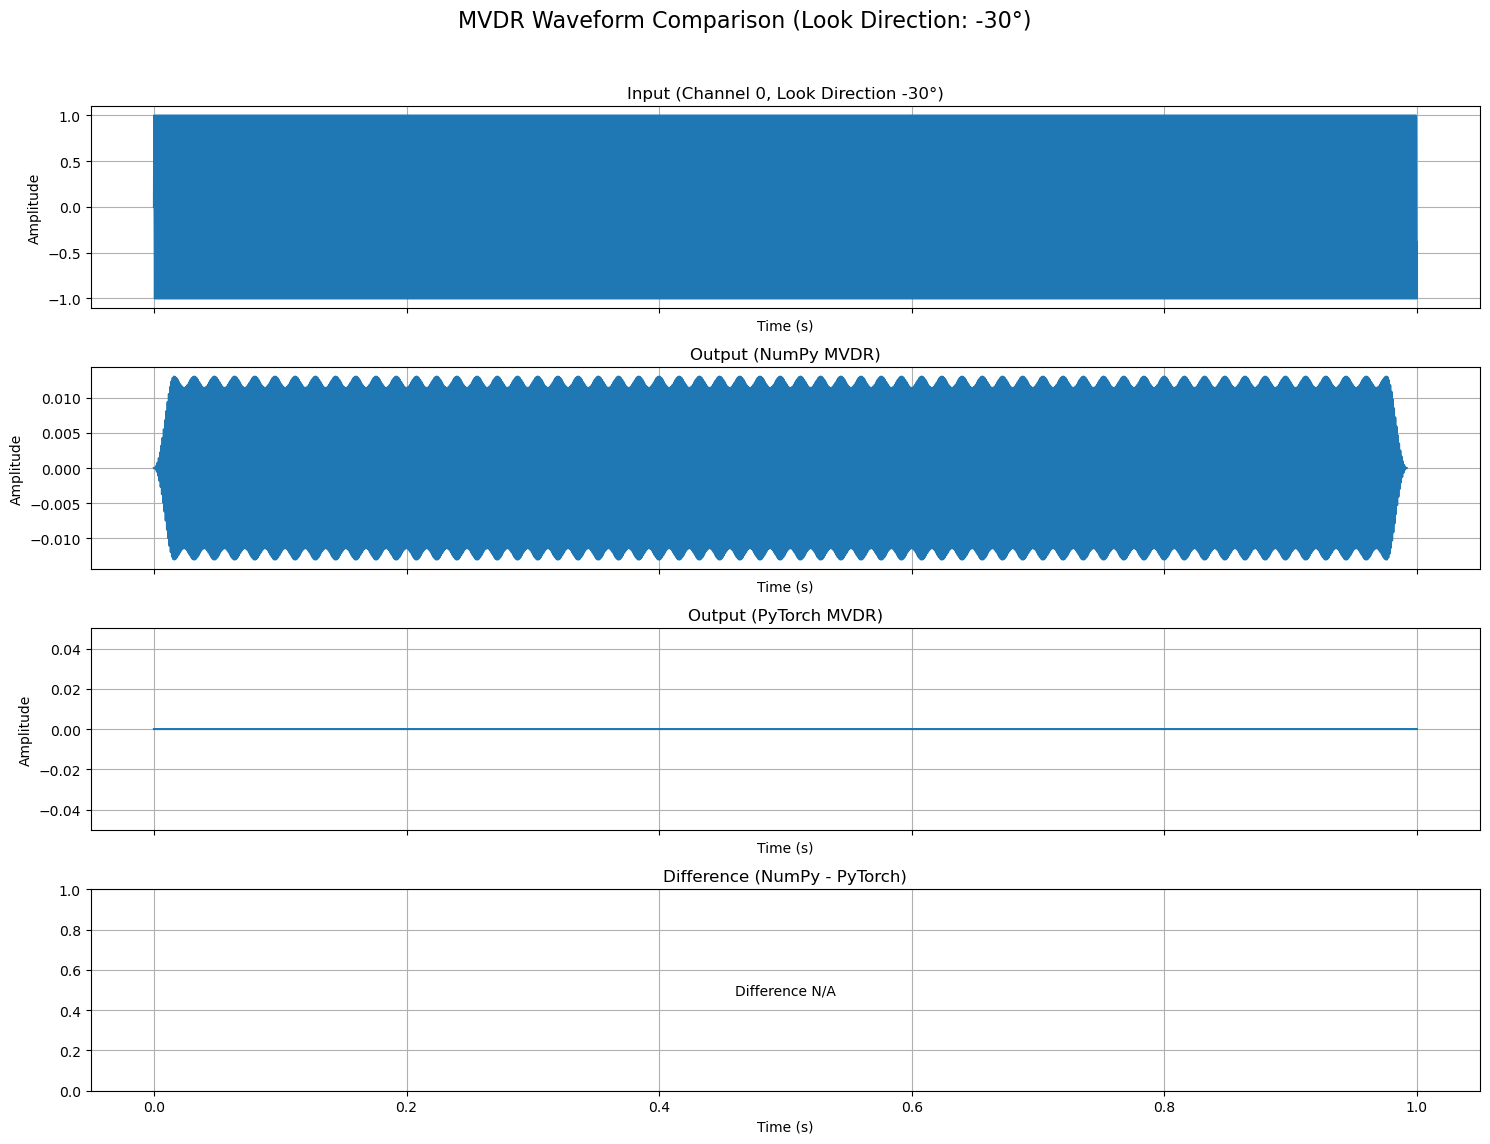

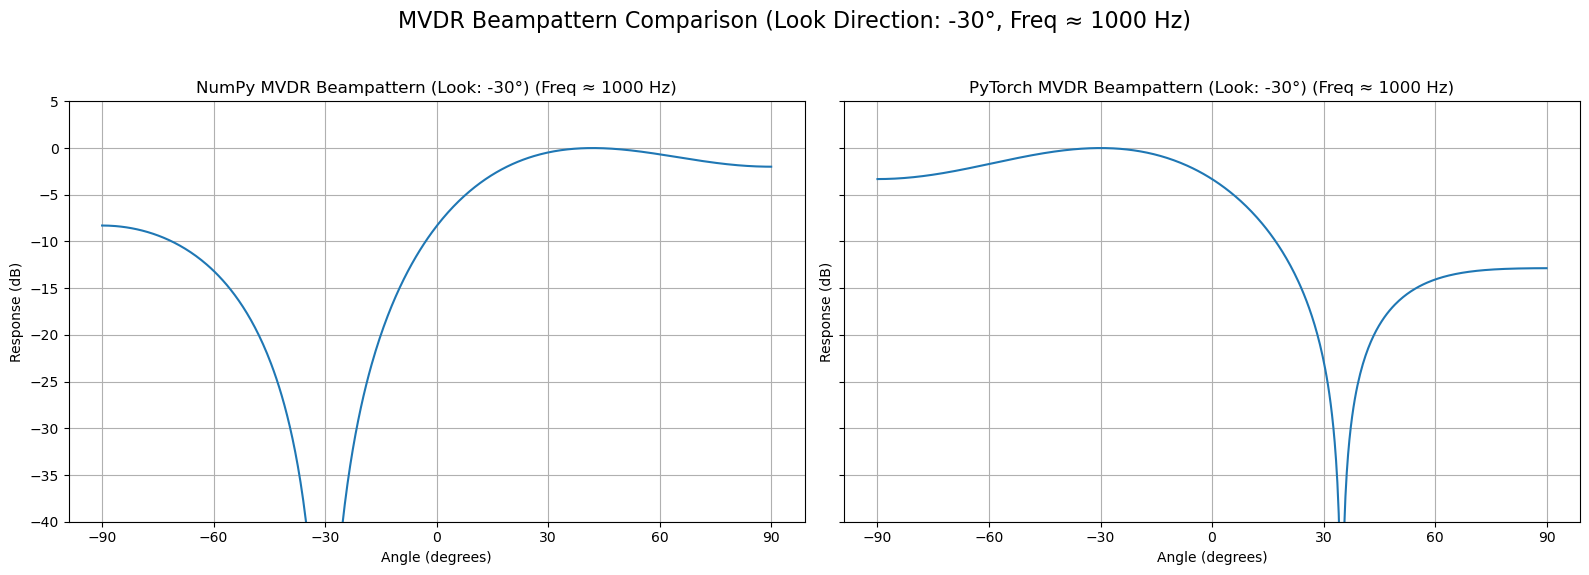

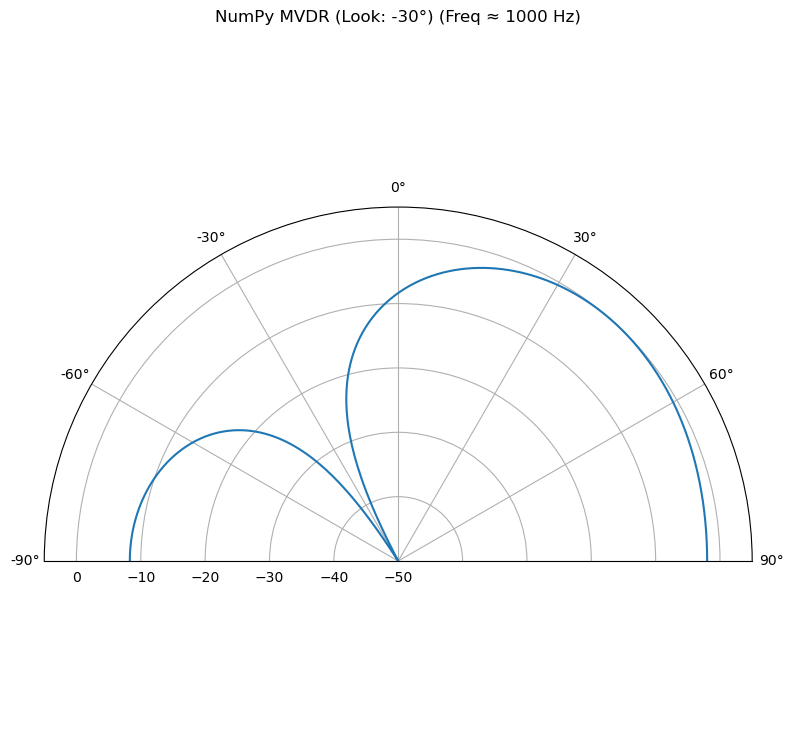

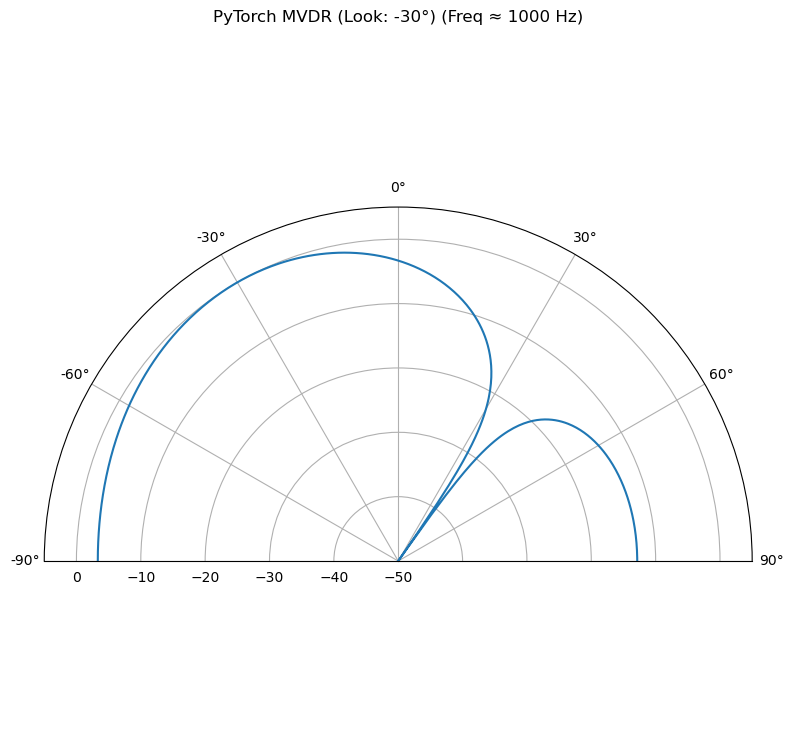


--------------------------------------------------
Processing for look direction: -18°
--------------------------------------------------
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

Target Source Position for Angle -18° (example distance):
[[-3.09016994]
 [ 9.51056516]
 [ 0.        ]]
Generated signals: mono (16000 samples), multi-channel (16000, 8), tensor torch.Size([8, 16000])
generate_audio_signals executed in: 0.0062 seconds
initialize_beamformers executed in: 0.0001 seconds

--- Steering Vector Calculation ---
Comparing Steering Vectors:
  Shapes: (8, 257) vs (8, 257)
  Max absolute difference: 5.89e-05
  Arrays are close (atol=1e-05): False

--- SCM Calculation ---
Comparing SCM Matrices:
  Shapes: (8, 8, 257) vs (8, 8, 257)
  Max absolute difference: 8.79e-03
  Arrays are close (atol=1e-05): True

--- MVDR Weights Calculation ---
Comparing MV

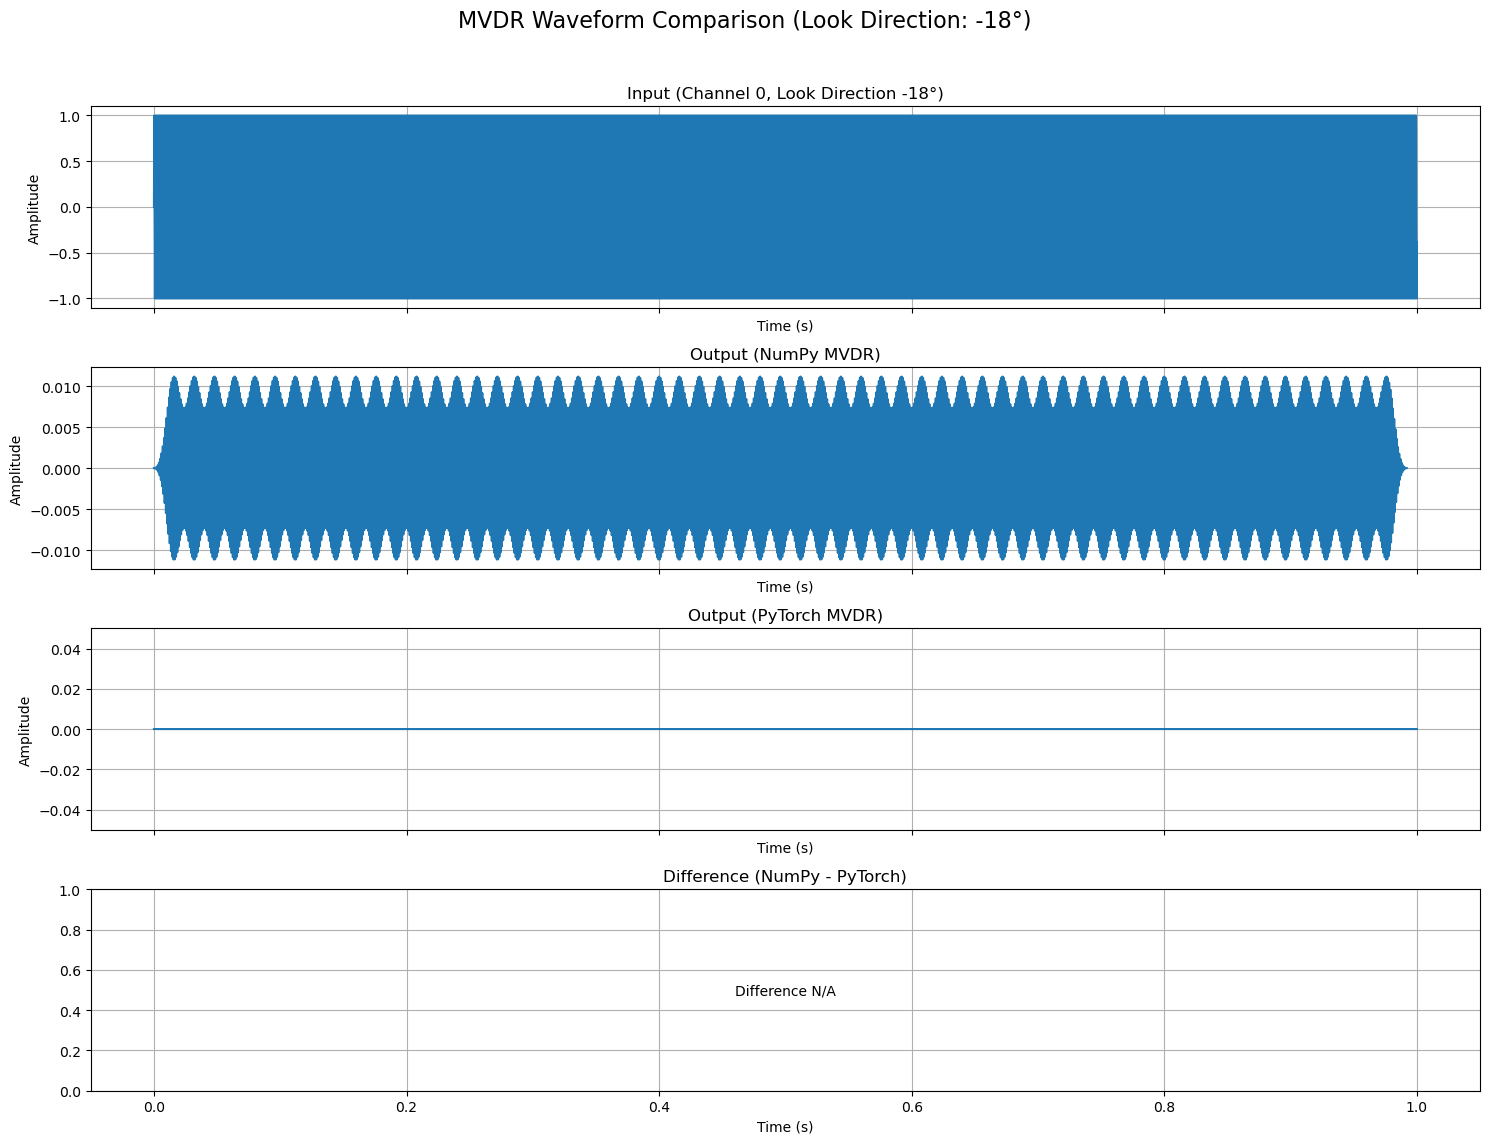

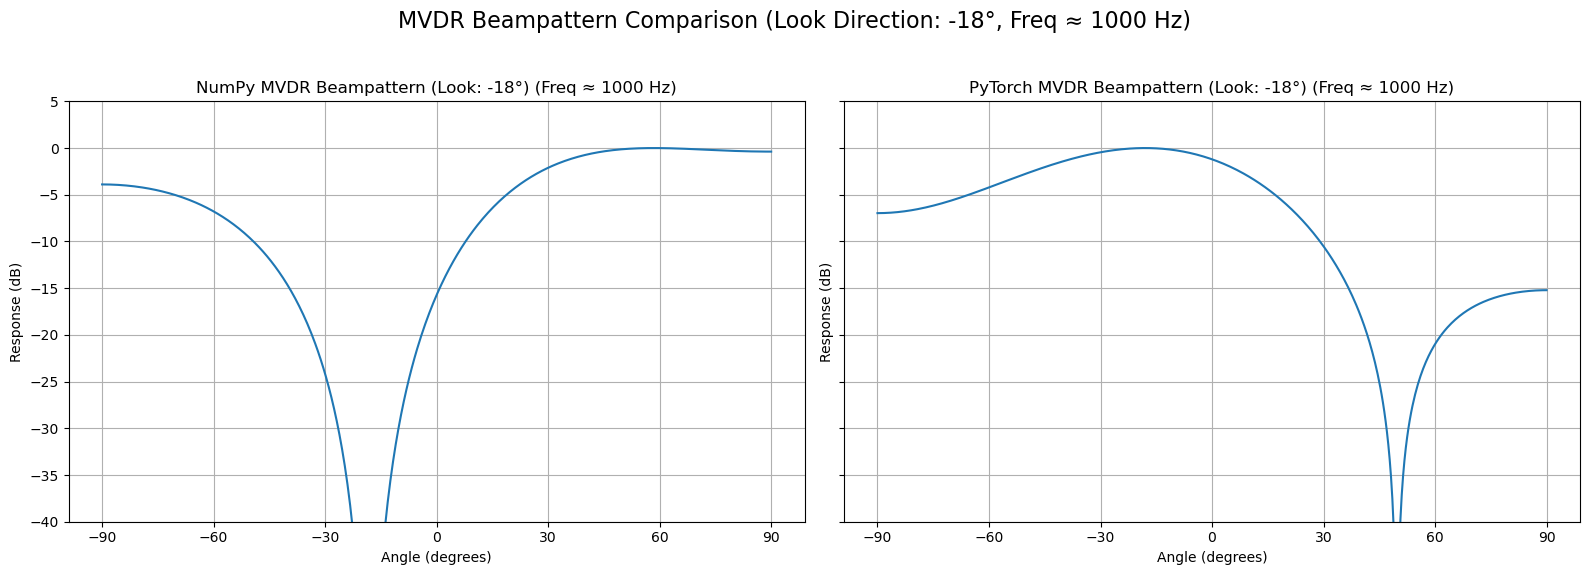

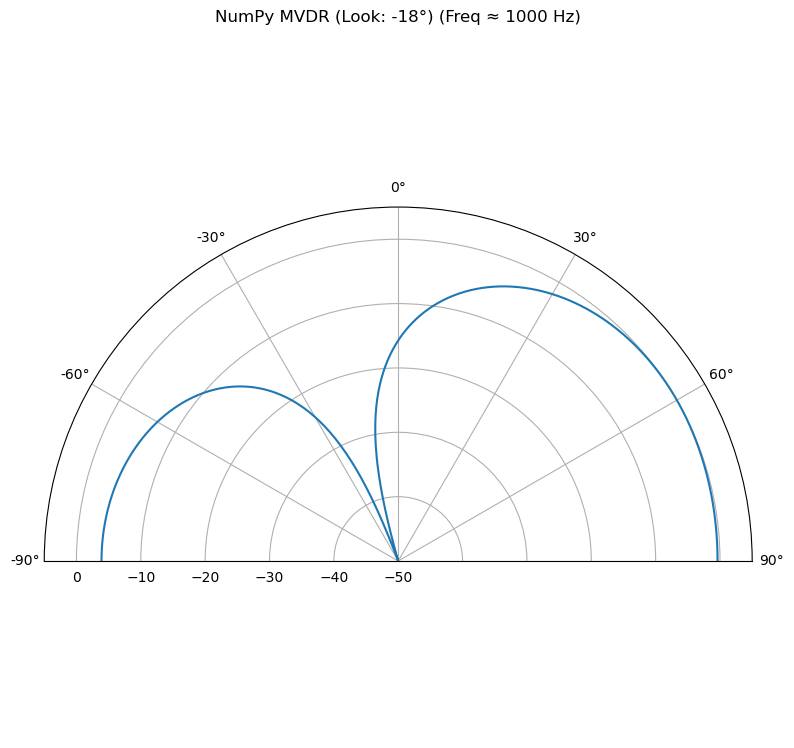

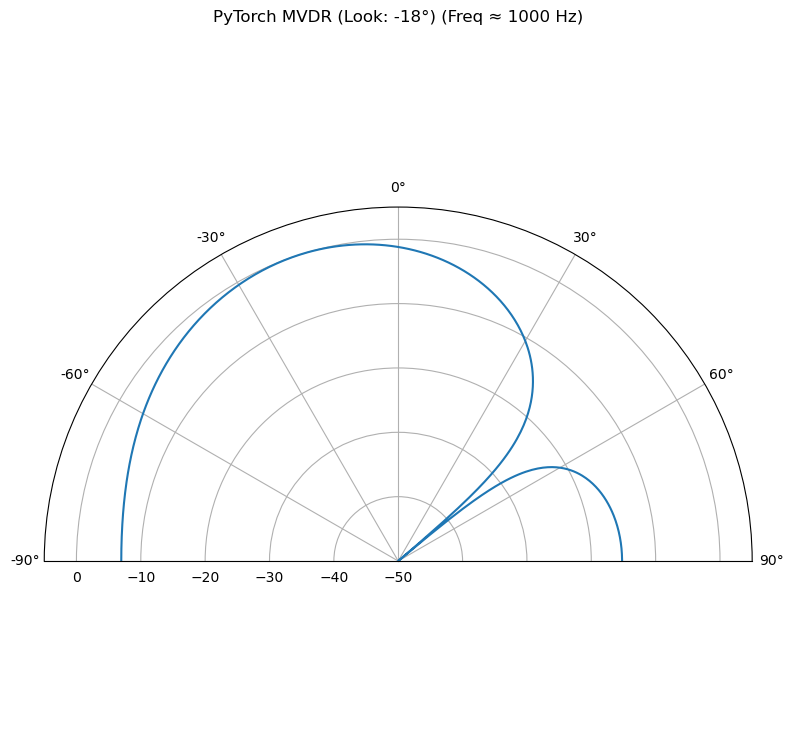


--------------------------------------------------
Processing for look direction: -6°
--------------------------------------------------
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

Target Source Position for Angle -6° (example distance):
[[-1.04528463]
 [ 9.94521895]
 [ 0.        ]]
Generated signals: mono (16000 samples), multi-channel (16000, 8), tensor torch.Size([8, 16000])
generate_audio_signals executed in: 0.0053 seconds
initialize_beamformers executed in: 0.0001 seconds

--- Steering Vector Calculation ---
Comparing Steering Vectors:
  Shapes: (8, 257) vs (8, 257)
  Max absolute difference: 1.11e-04
  Arrays are close (atol=1e-05): False

--- SCM Calculation ---
Comparing SCM Matrices:
  Shapes: (8, 8, 257) vs (8, 8, 257)
  Max absolute difference: 7.18e-03
  Arrays are close (atol=1e-05): True

--- MVDR Weights Calculation ---
Comparing MVDR

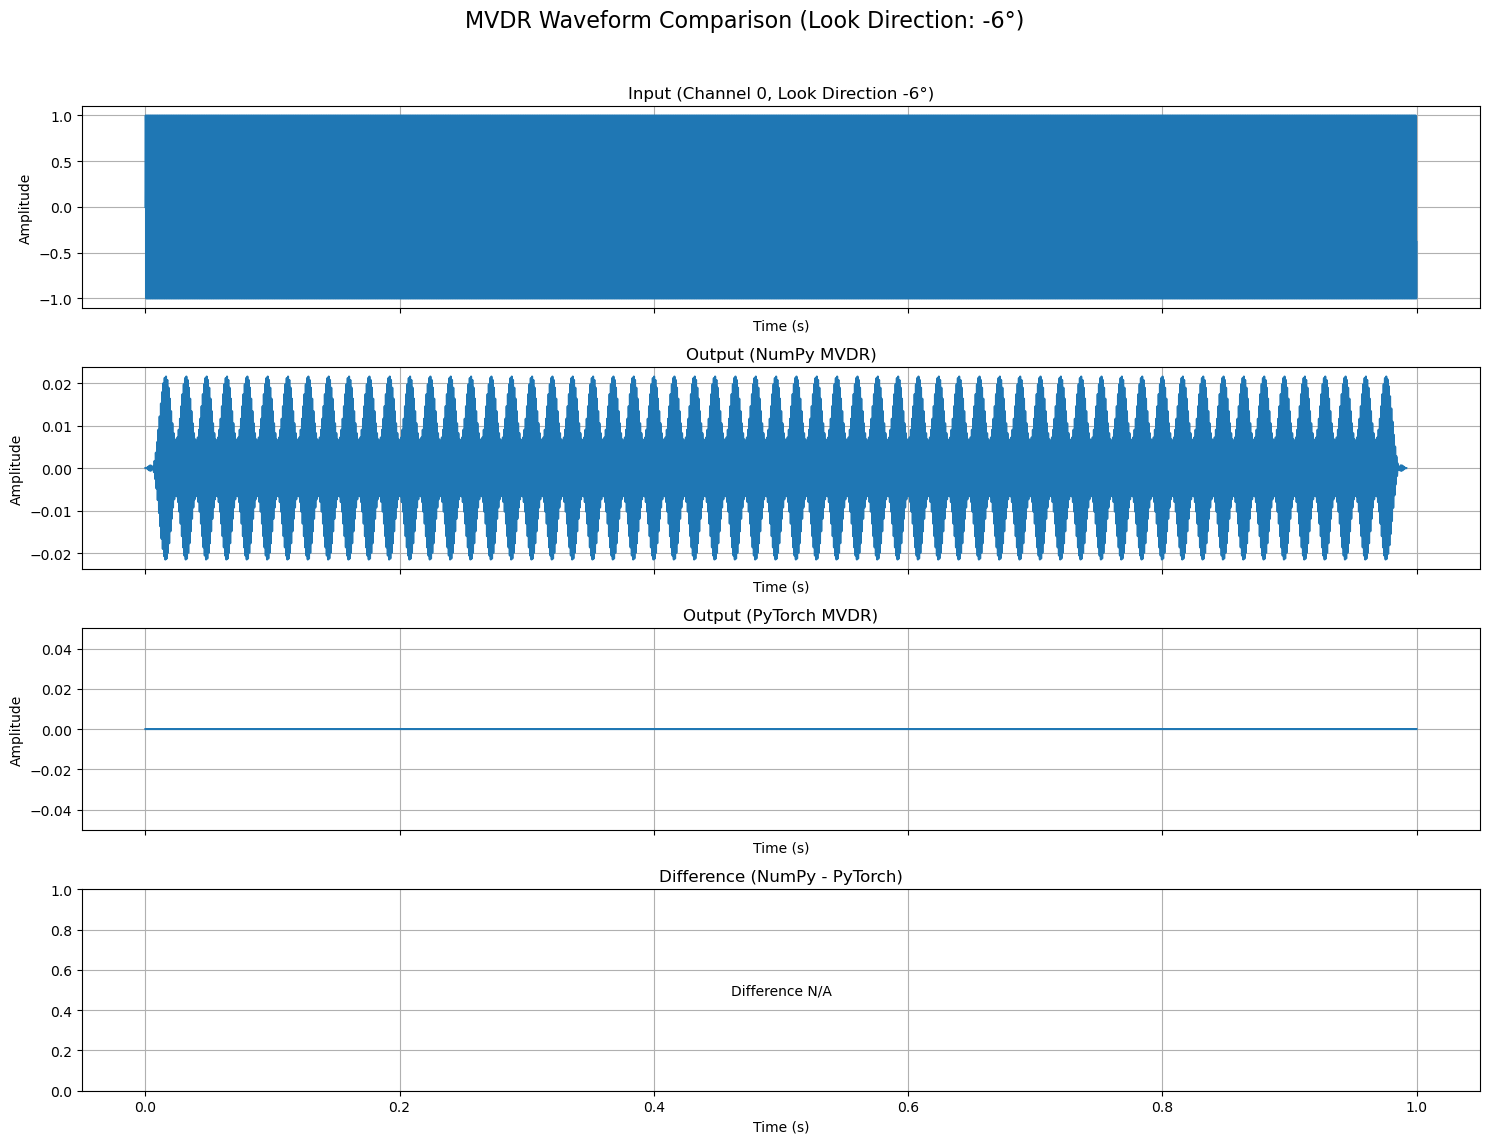

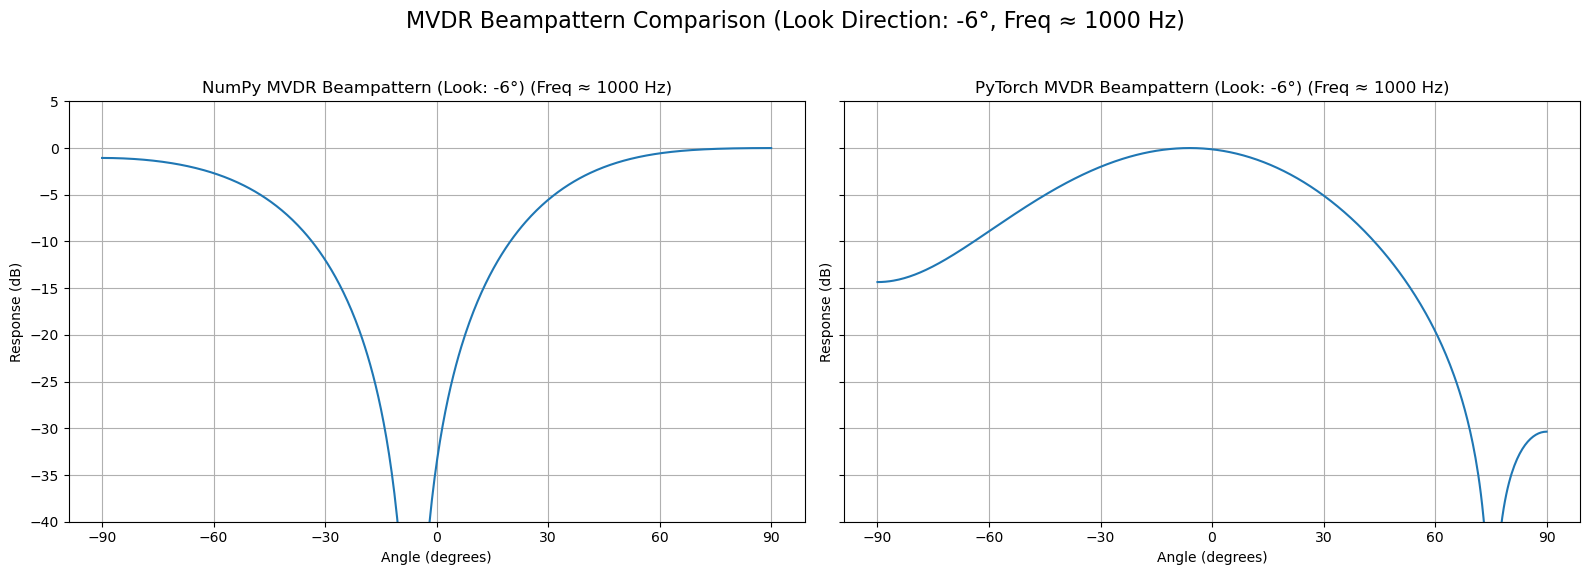

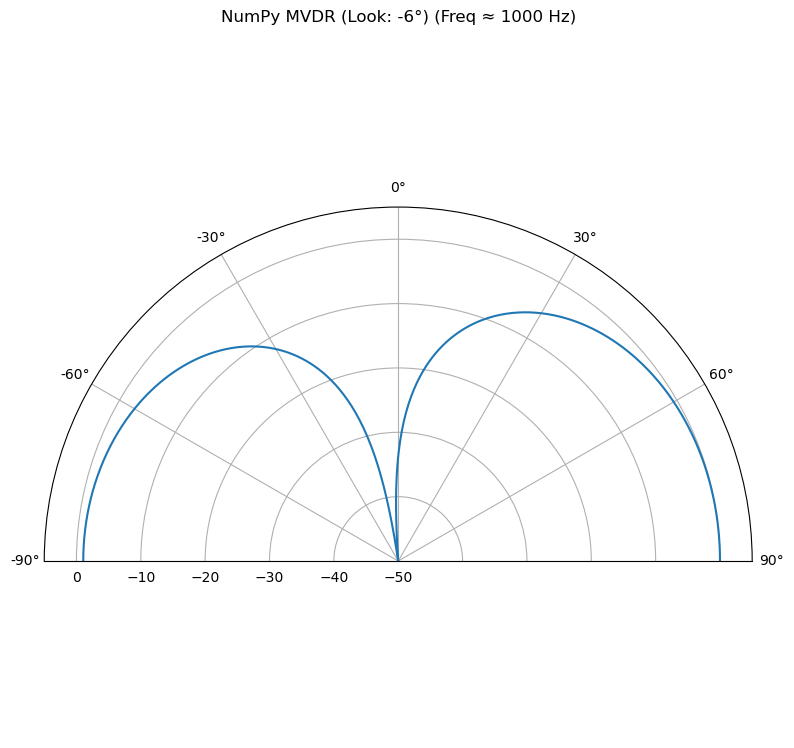

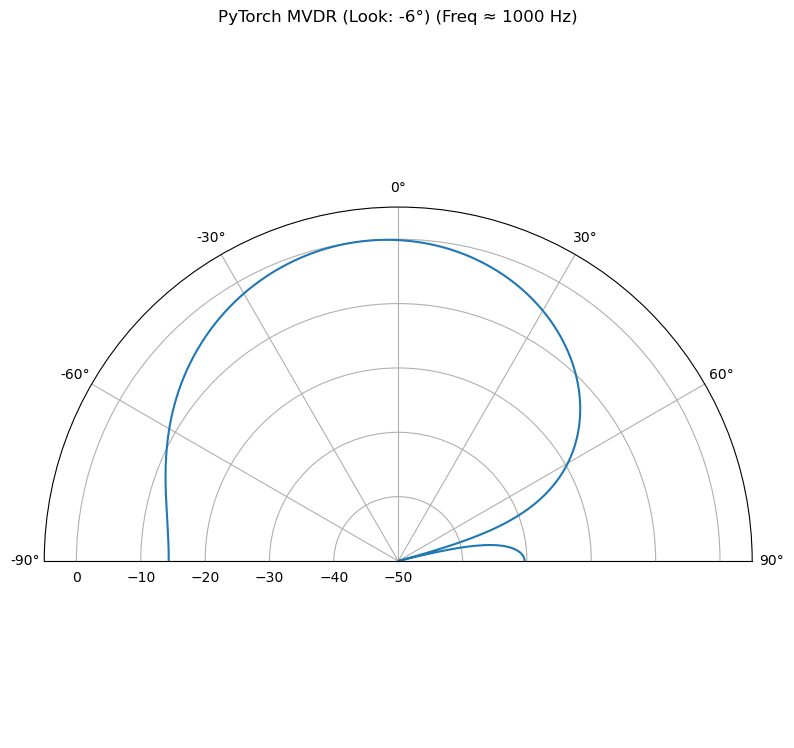


--------------------------------------------------
Processing for look direction: 0°
--------------------------------------------------
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

Target Source Position for Angle 0° (example distance):
[[6.123234e-16]
 [1.000000e+01]
 [0.000000e+00]]
Generated signals: mono (16000 samples), multi-channel (16000, 8), tensor torch.Size([8, 16000])
generate_audio_signals executed in: 0.0048 seconds
initialize_beamformers executed in: 0.0001 seconds

--- Steering Vector Calculation ---
Comparing Steering Vectors:
  Shapes: (8, 257) vs (8, 257)
  Max absolute difference: 1.01e-04
  Arrays are close (atol=1e-05): False

--- SCM Calculation ---
Comparing SCM Matrices:
  Shapes: (8, 8, 257) vs (8, 8, 257)
  Max absolute difference: 9.77e-04
  Arrays are close (atol=1e-05): True

--- MVDR Weights Calculation ---
Comparing MVD

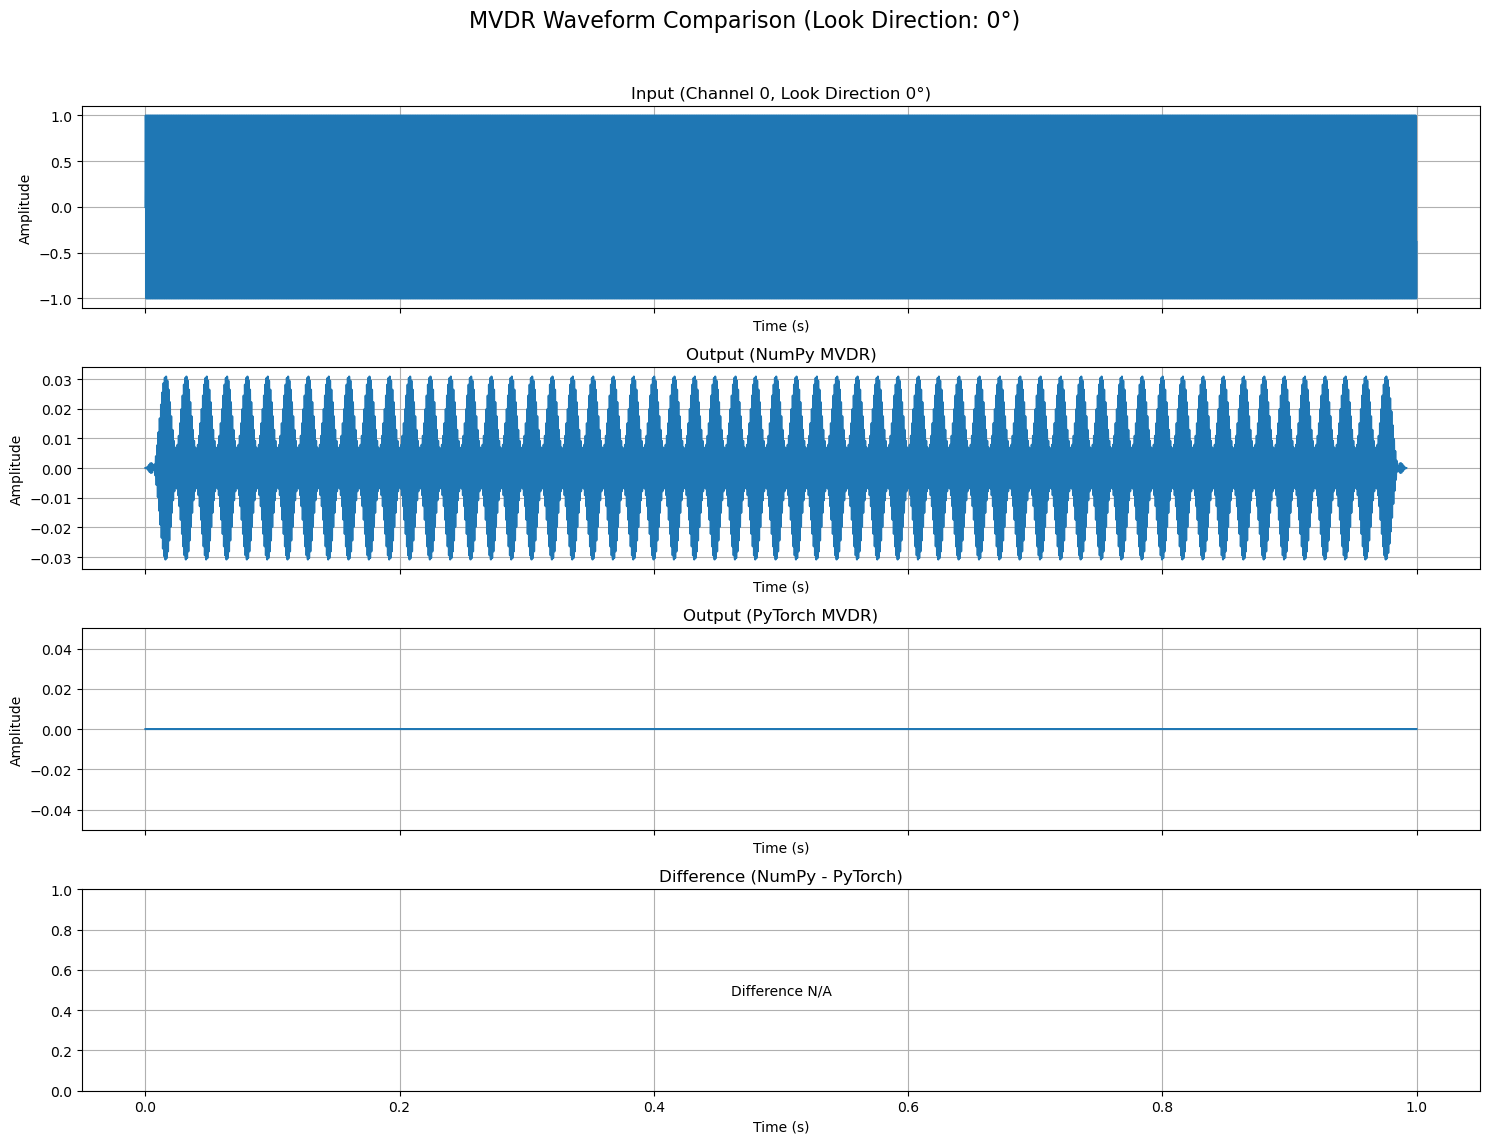

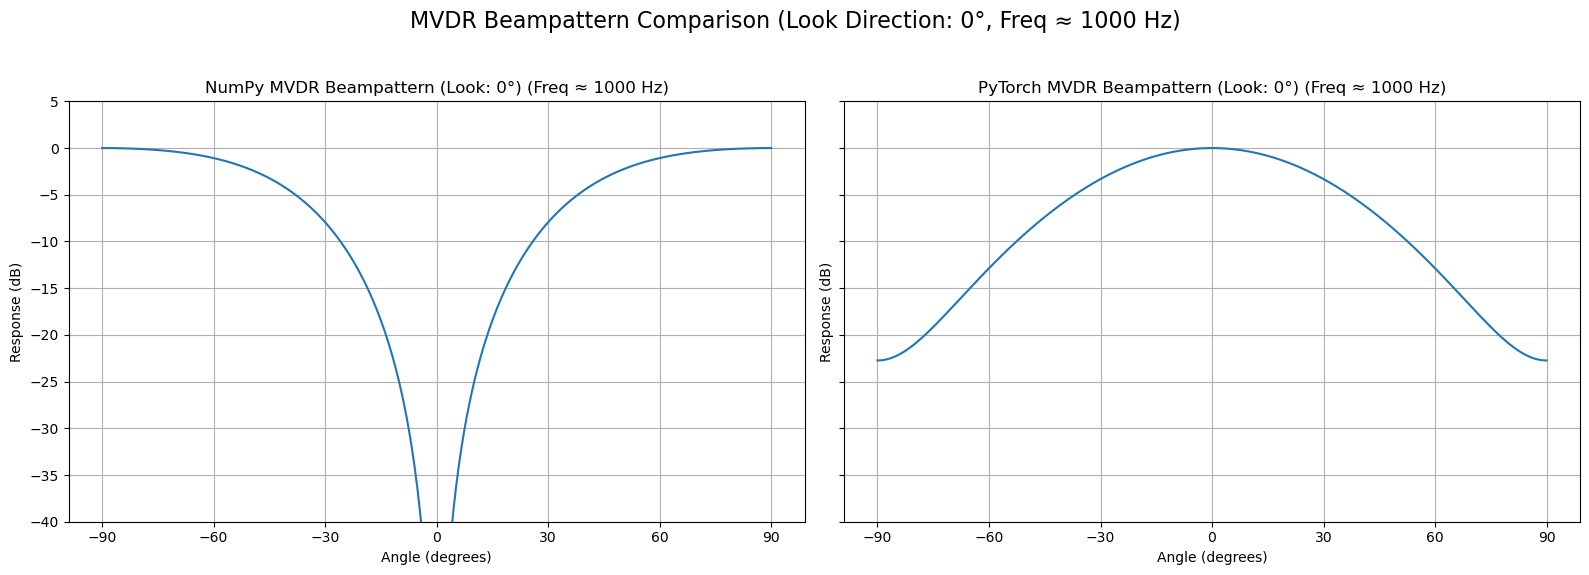

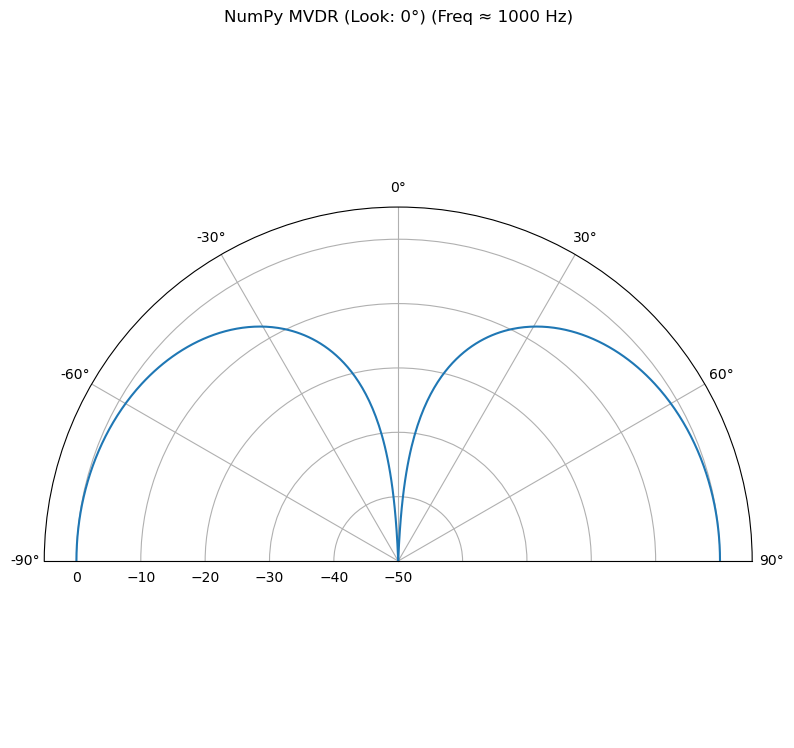

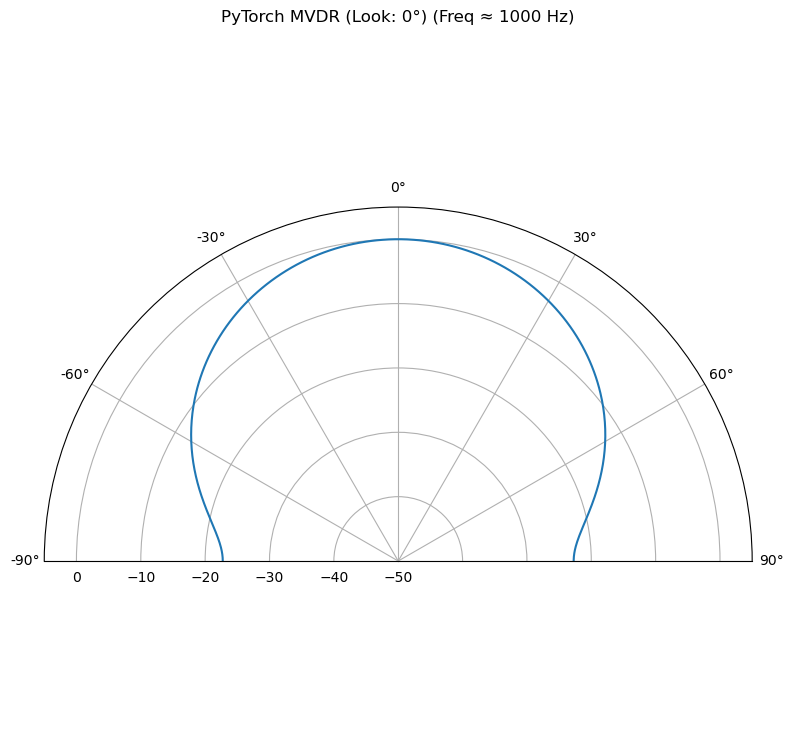


--------------------------------------------------
Processing for look direction: 6°
--------------------------------------------------
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

Target Source Position for Angle 6° (example distance):
[[1.04528463]
 [9.94521895]
 [0.        ]]
Generated signals: mono (16000 samples), multi-channel (16000, 8), tensor torch.Size([8, 16000])
generate_audio_signals executed in: 0.0058 seconds
initialize_beamformers executed in: 0.0001 seconds

--- Steering Vector Calculation ---
Comparing Steering Vectors:
  Shapes: (8, 257) vs (8, 257)
  Max absolute difference: 1.11e-04
  Arrays are close (atol=1e-05): False

--- SCM Calculation ---
Comparing SCM Matrices:
  Shapes: (8, 8, 257) vs (8, 8, 257)
  Max absolute difference: 6.91e-03
  Arrays are close (atol=1e-05): True

--- MVDR Weights Calculation ---
Comparing MVDR Weig

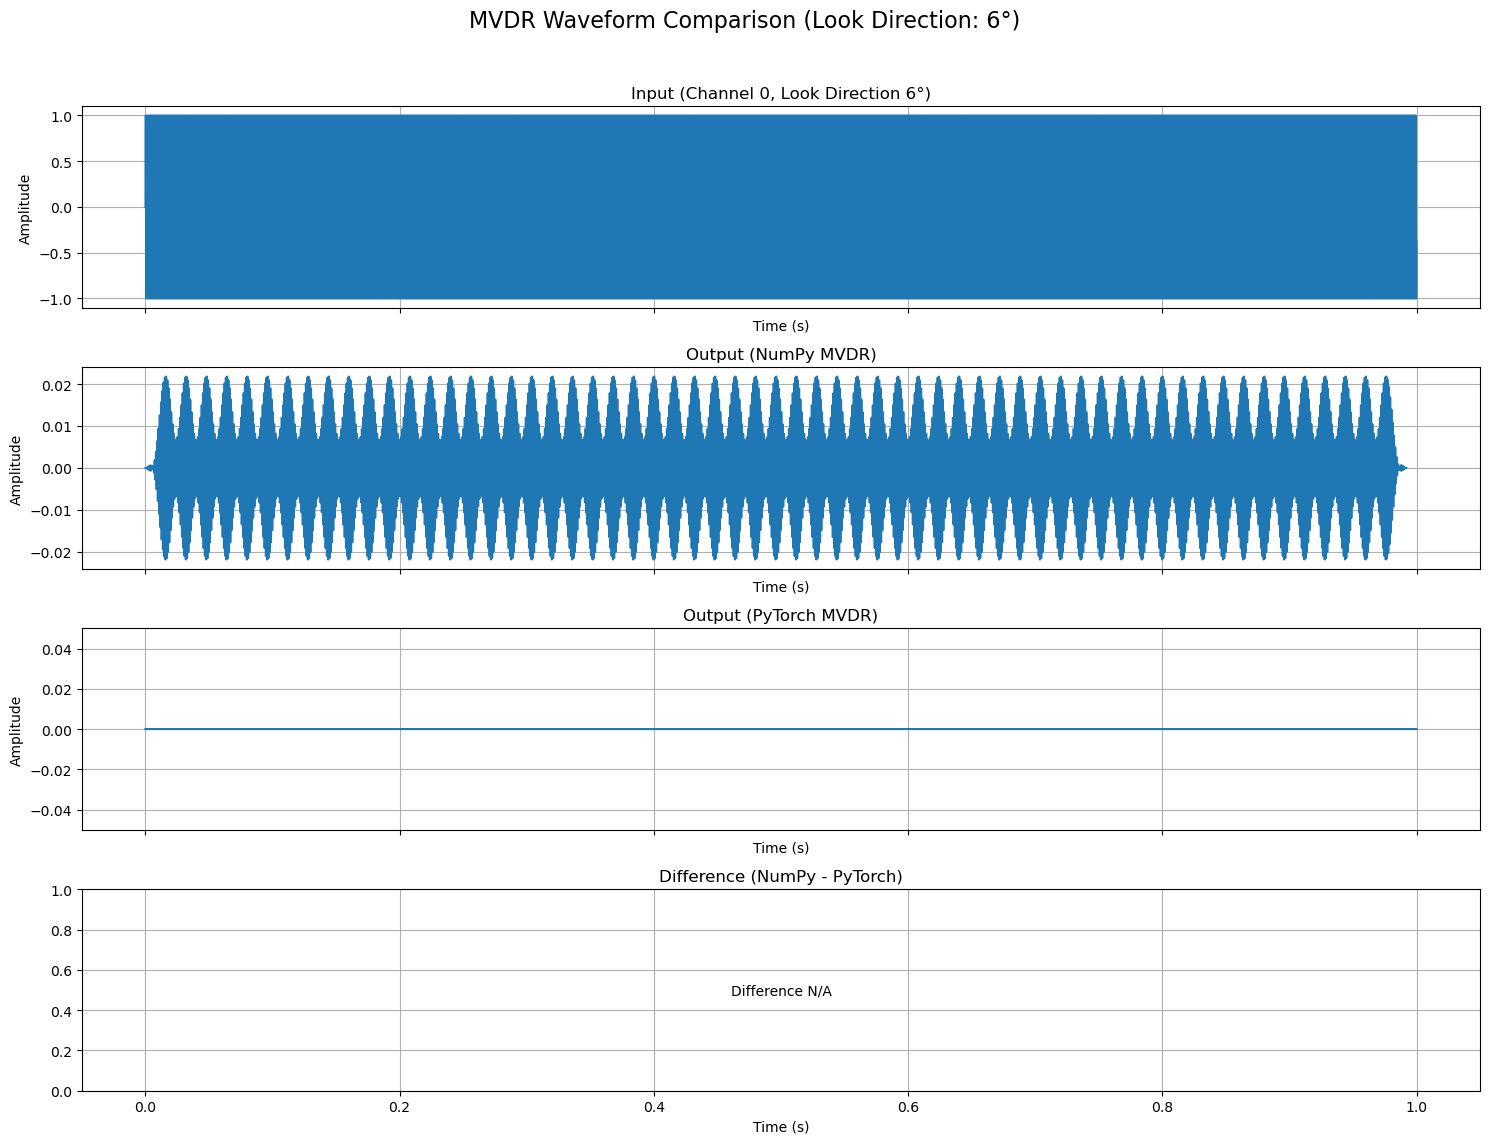

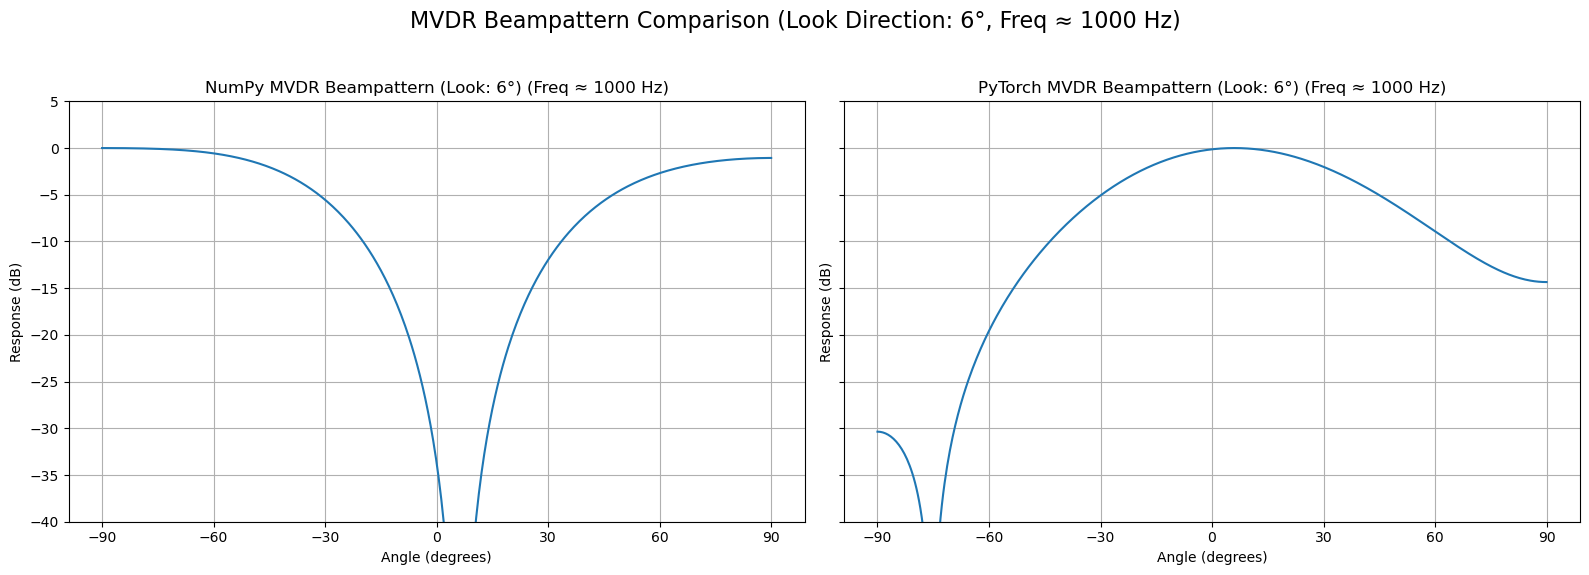

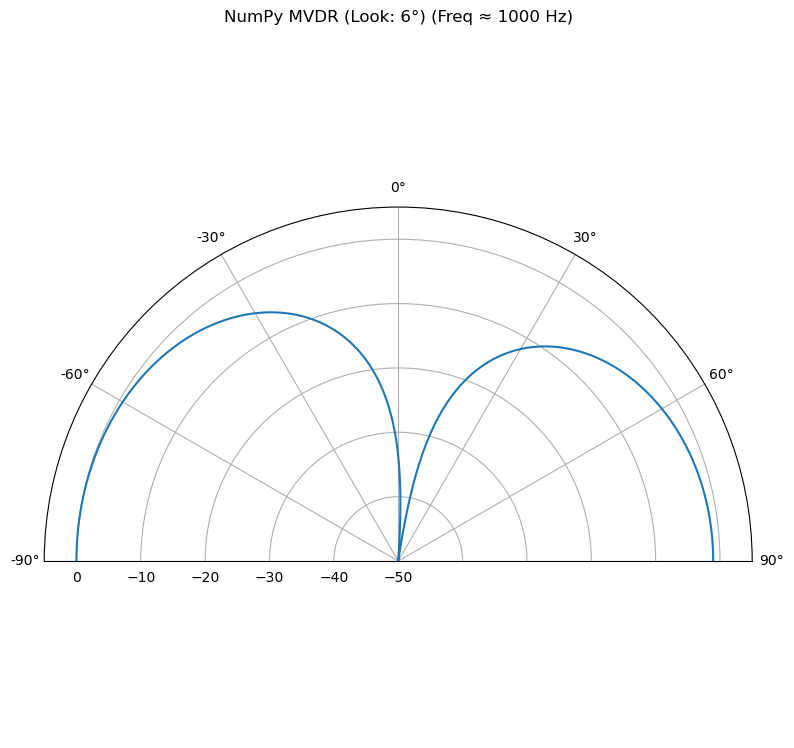

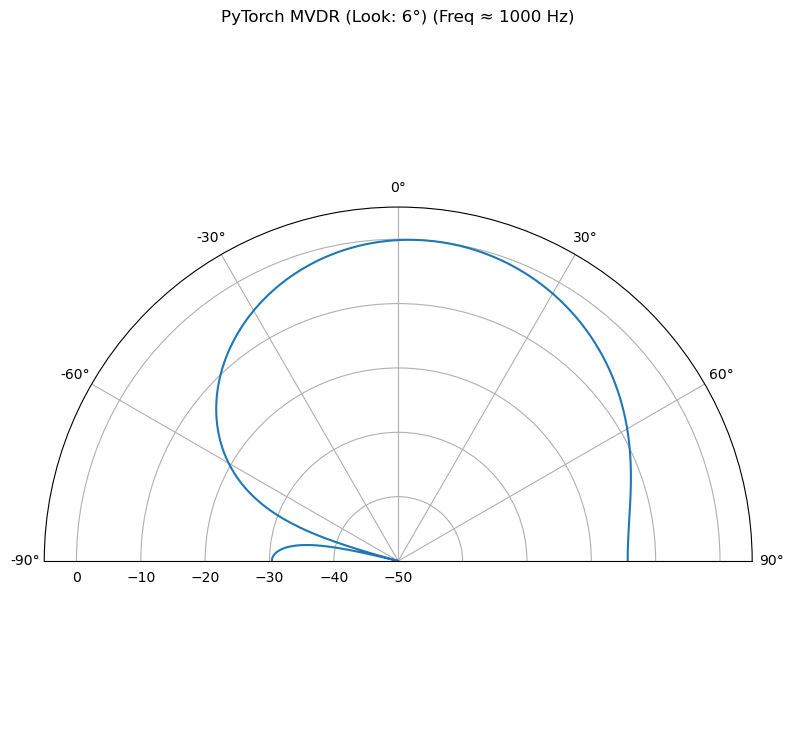


--------------------------------------------------
Processing for look direction: 18°
--------------------------------------------------
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

Target Source Position for Angle 18° (example distance):
[[3.09016994]
 [9.51056516]
 [0.        ]]
Generated signals: mono (16000 samples), multi-channel (16000, 8), tensor torch.Size([8, 16000])
generate_audio_signals executed in: 0.0065 seconds
initialize_beamformers executed in: 0.0001 seconds

--- Steering Vector Calculation ---
Comparing Steering Vectors:
  Shapes: (8, 257) vs (8, 257)
  Max absolute difference: 5.89e-05
  Arrays are close (atol=1e-05): False

--- SCM Calculation ---
Comparing SCM Matrices:
  Shapes: (8, 8, 257) vs (8, 8, 257)
  Max absolute difference: 6.35e-03
  Arrays are close (atol=1e-05): True

--- MVDR Weights Calculation ---
Comparing MVDR We

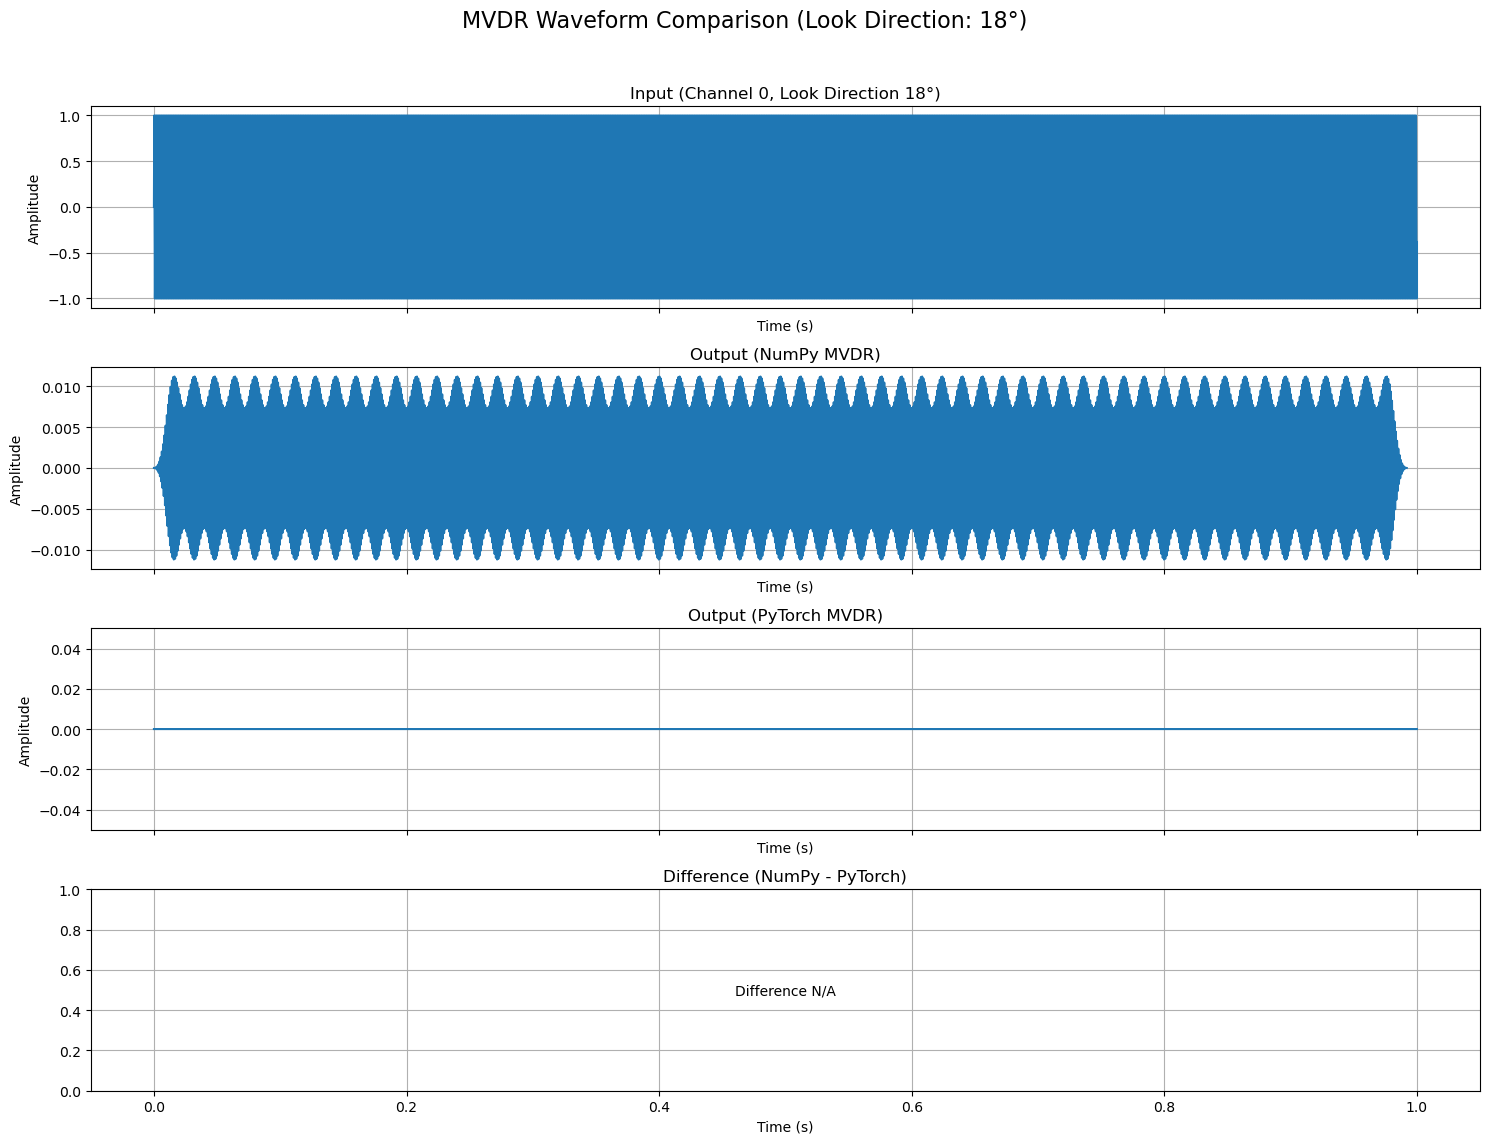

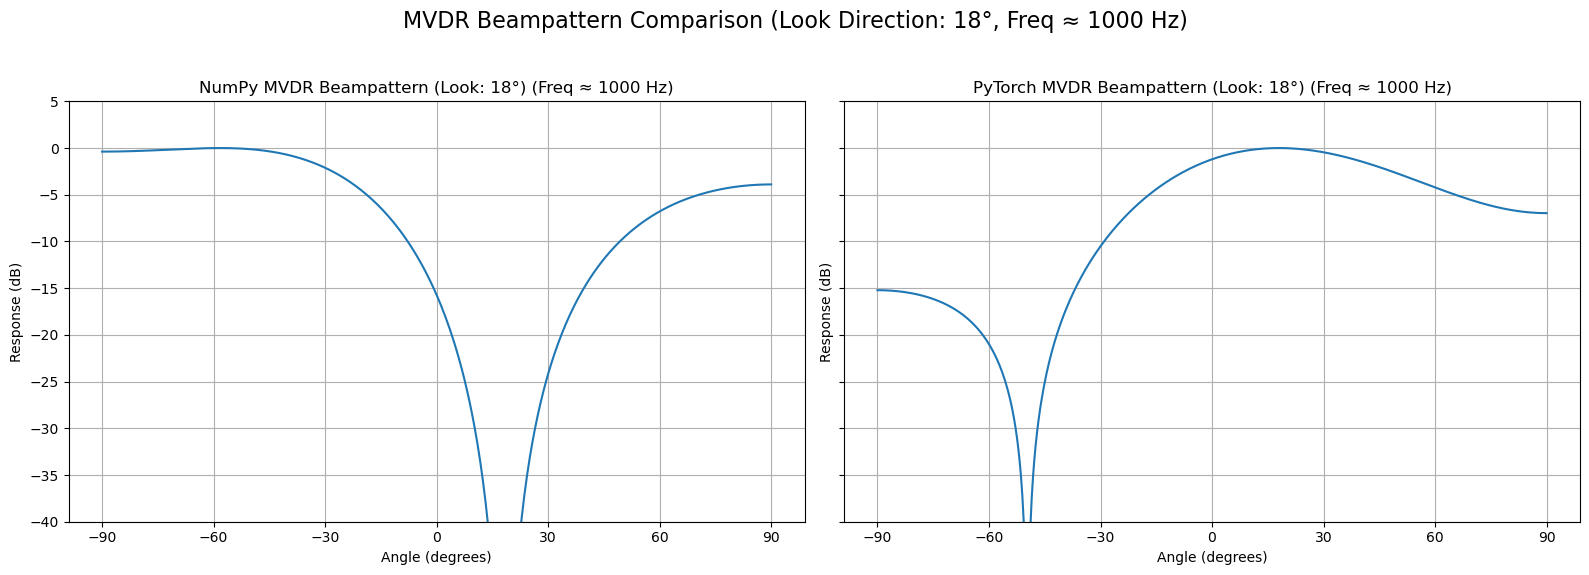

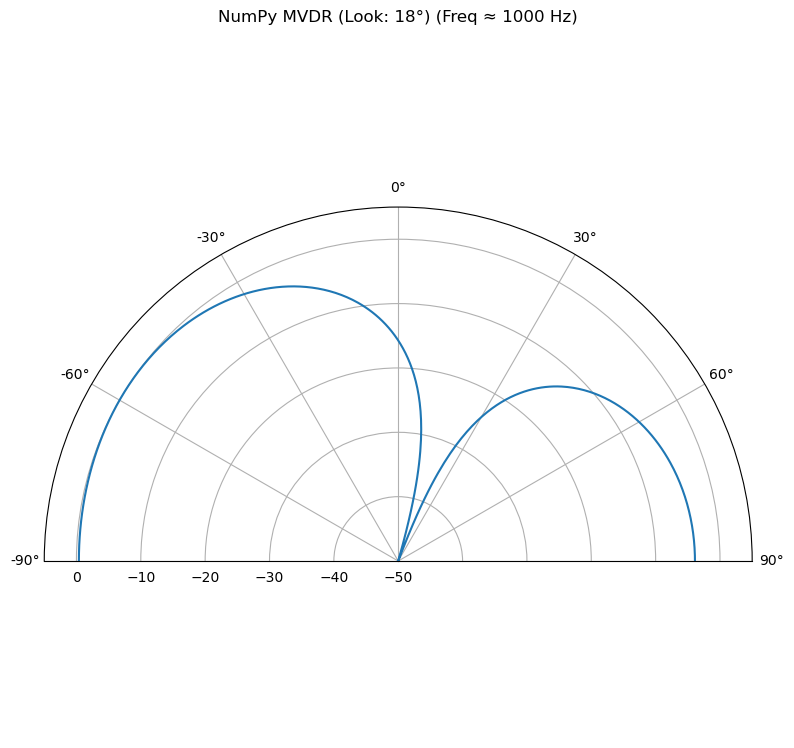

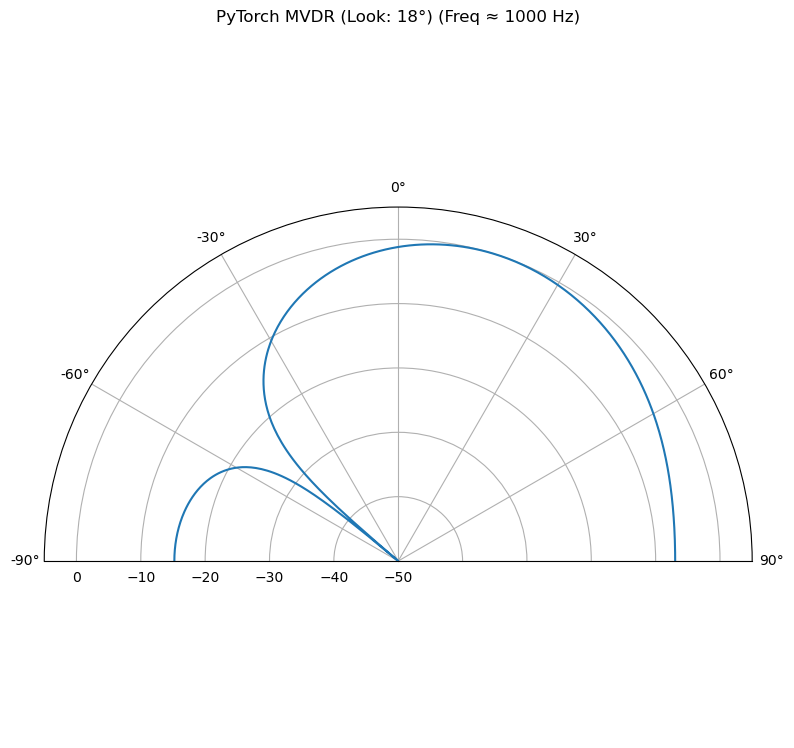


--------------------------------------------------
Processing for look direction: 30°
--------------------------------------------------
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

Target Source Position for Angle 30° (example distance):
[[5.        ]
 [8.66025404]
 [0.        ]]
Generated signals: mono (16000 samples), multi-channel (16000, 8), tensor torch.Size([8, 16000])
generate_audio_signals executed in: 0.0059 seconds
initialize_beamformers executed in: 0.0001 seconds

--- Steering Vector Calculation ---
Comparing Steering Vectors:
  Shapes: (8, 257) vs (8, 257)
  Max absolute difference: 1.18e-04
  Arrays are close (atol=1e-05): False

--- SCM Calculation ---
Comparing SCM Matrices:
  Shapes: (8, 8, 257) vs (8, 8, 257)
  Max absolute difference: 6.25e-03
  Arrays are close (atol=1e-05): True

--- MVDR Weights Calculation ---
Comparing MVDR We

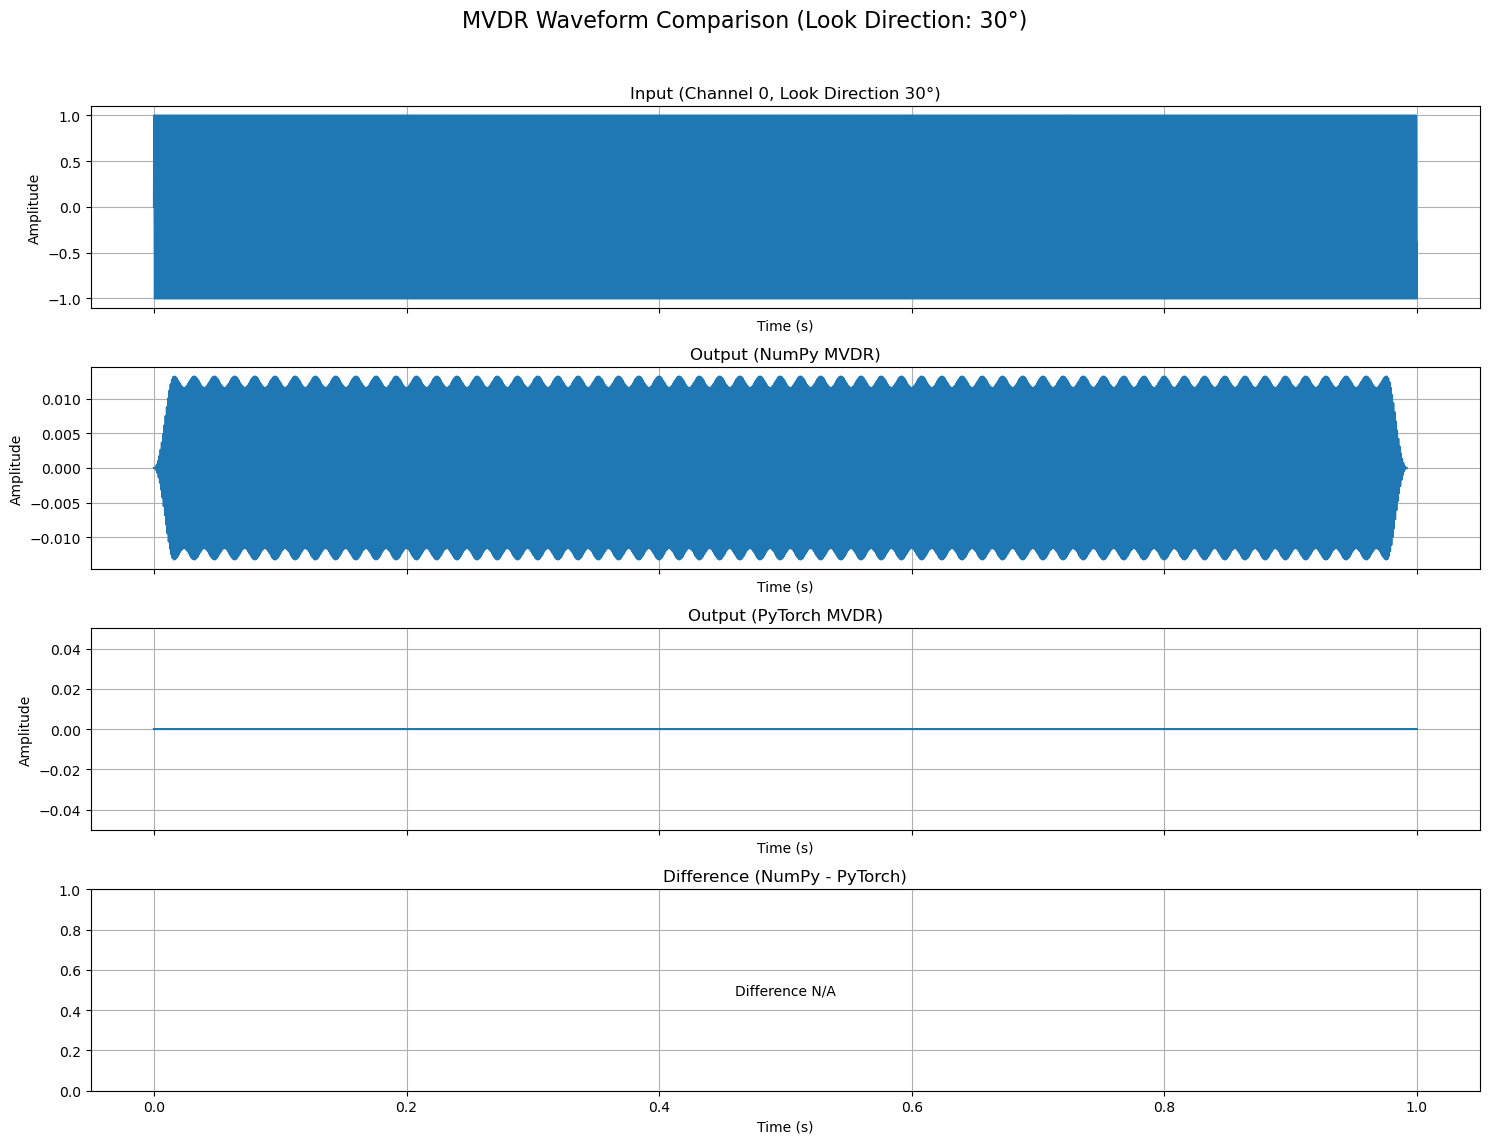

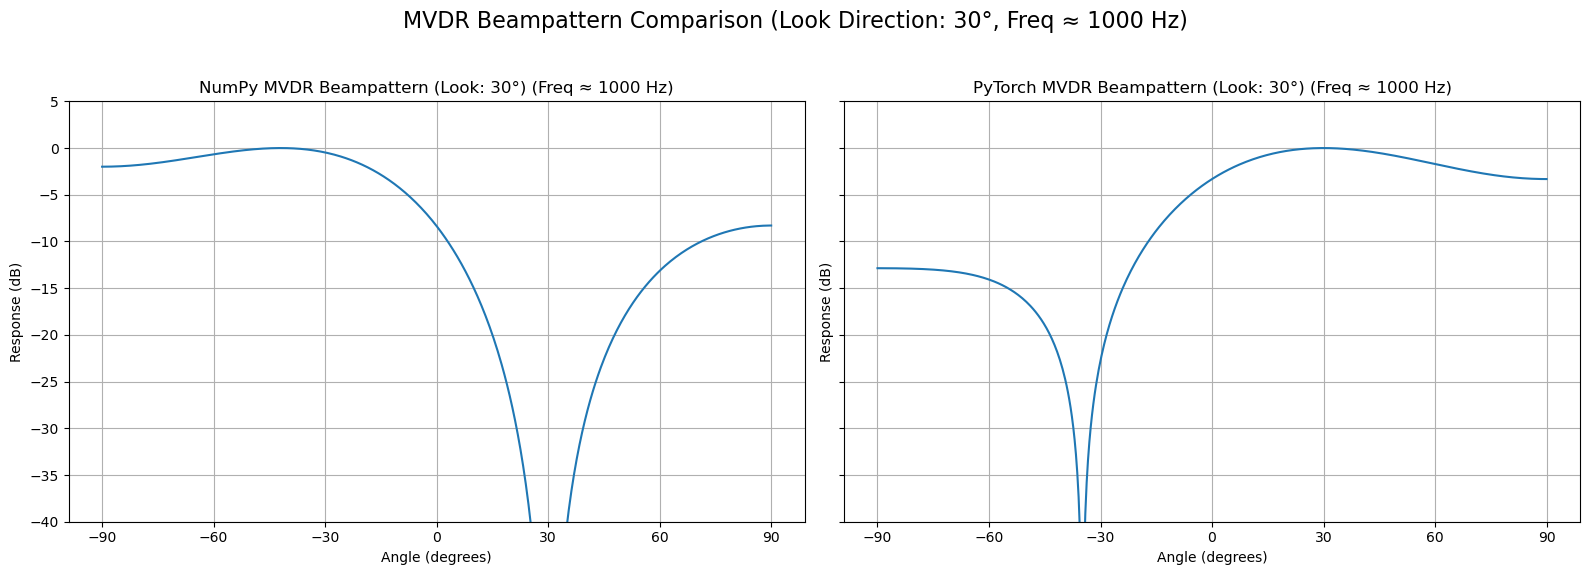

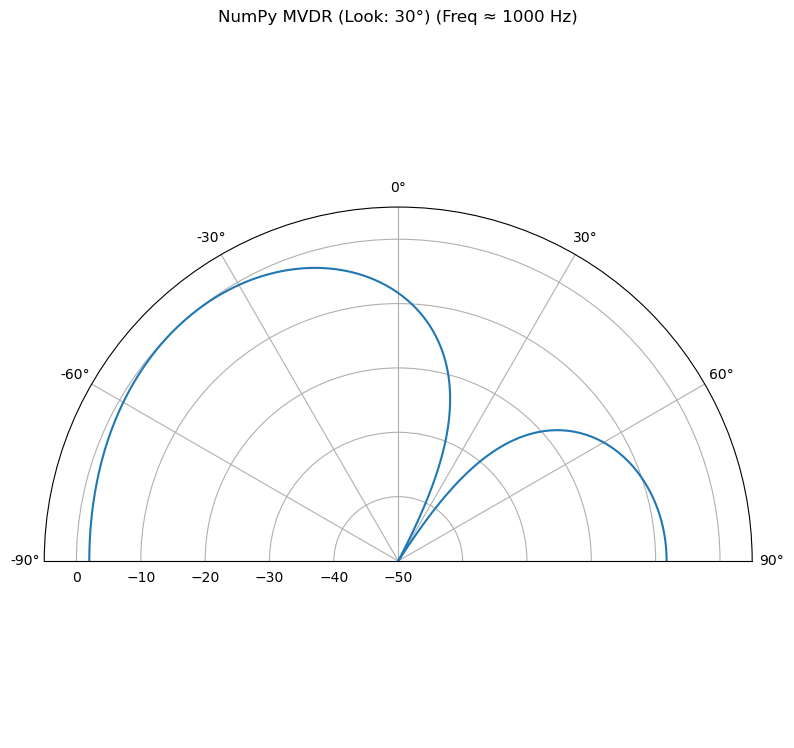

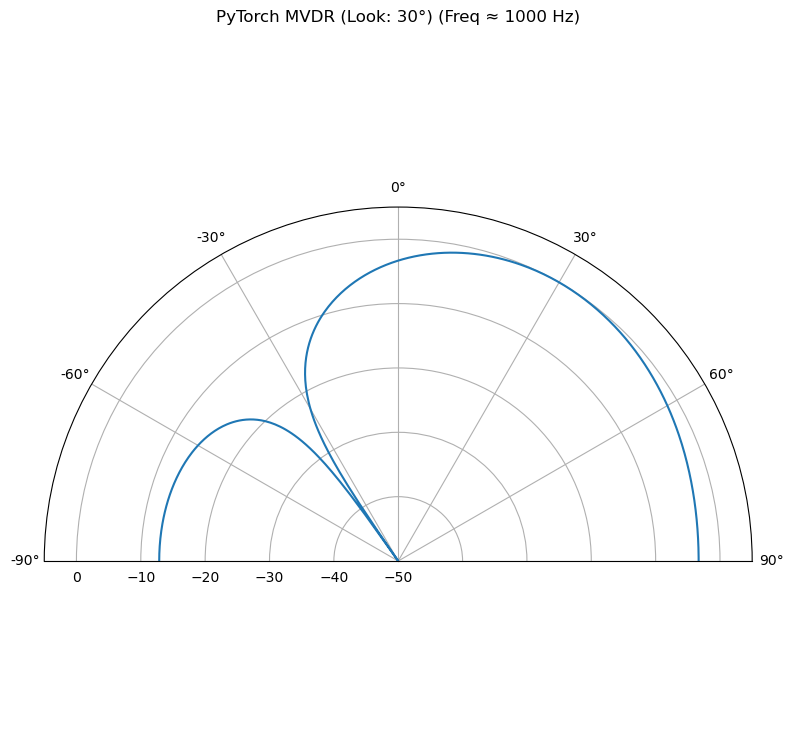

In [12]:
# Dictionary to store results for each angle
all_results = {}

# Process each requested look direction
for angle in TEST_ANGLES:
    result = process_for_look_direction(angle, save_plots=True)
    all_results[angle] = result

## 7. Summarize Results

In [13]:
# Summarize the results across all tested angles
print("\n" + "="*80)
print("MVDR COMPARISON SUMMARY ACROSS ALL TESTED ANGLES")
print("="*80)

# Extract results for tabulation
angles = []
rmse_values = []
power_ratios = []
speedups = []

print(f"\n{'Look Direction':<15} {'RMSE':<15} {'Power Ratio (dB)':<20} {'Total Speedup':<15}")
print("-" * 70)

for angle, result in all_results.items():
    angles.append(angle)
    rmse_values.append(result['rmse'])
    power_ratios.append(result['power_ratio_db'])
    
    np_time = result['timing_results']['numpy']['total']
    pt_time = result['timing_results']['pytorch']['total']
    speedup = np_time / pt_time if pt_time > 0 else float('inf')
    speedups.append(speedup)
    
    print(f"{angle:^15.1f} {result['rmse']:^15.2e} {result['power_ratio_db']:^20.2f} {speedup:^15.2f}")

# Calculate averages
avg_rmse = np.mean(rmse_values)
avg_power_ratio = np.mean(power_ratios)
avg_speedup = np.mean(speedups)

print("-" * 70)
print(f"{'Average':^15} {avg_rmse:^15.2e} {avg_power_ratio:^20.2f} {avg_speedup:^15.2f}")


MVDR COMPARISON SUMMARY ACROSS ALL TESTED ANGLES

Look Direction  RMSE            Power Ratio (dB)     Total Speedup  
----------------------------------------------------------------------
     -30.0            nan               nan               0.54      
     -18.0            nan               nan               1.03      
     -6.0             nan               nan               0.76      
      0.0             nan               nan               1.06      
      6.0             nan               nan               0.93      
     18.0             nan               nan               0.97      
     30.0             nan               nan               1.01      
----------------------------------------------------------------------
    Average           nan               nan               0.90      


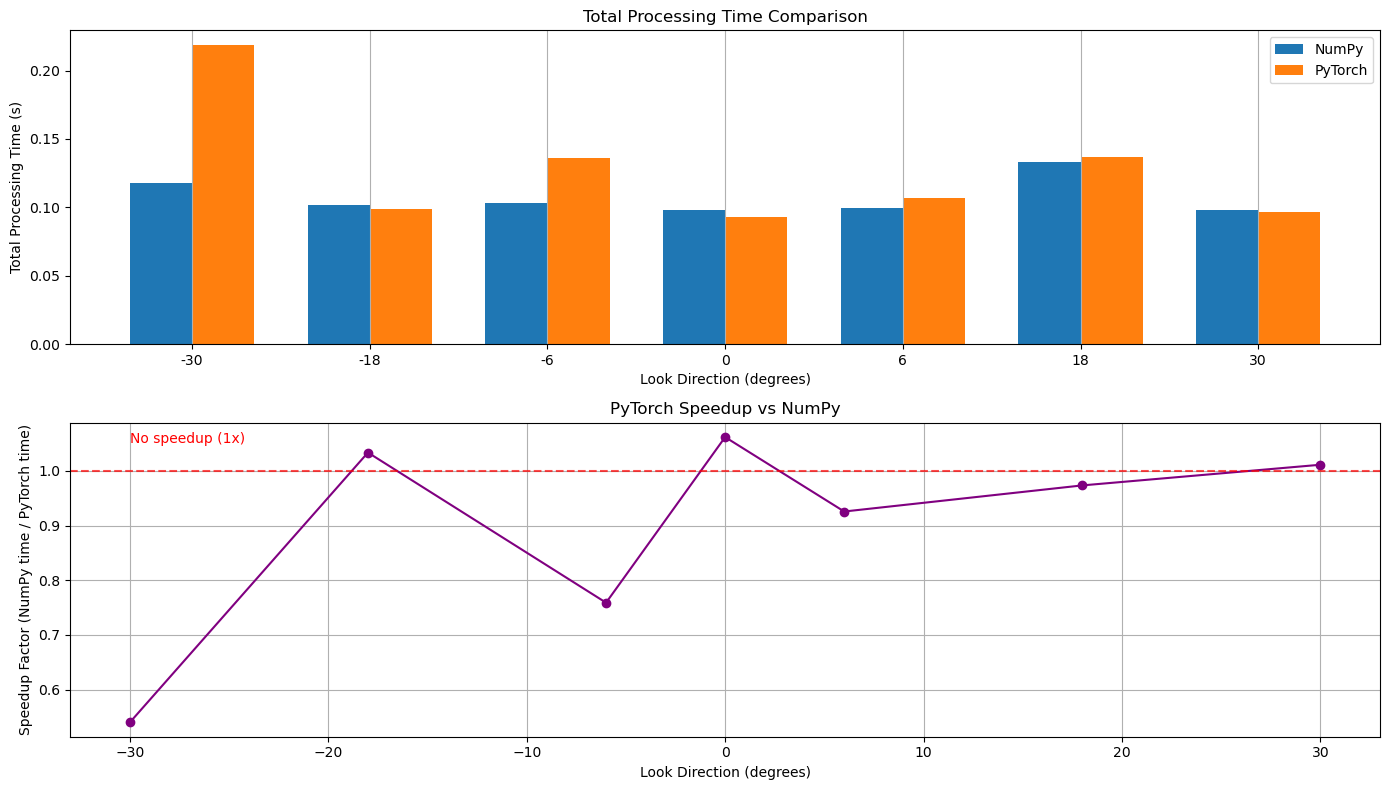

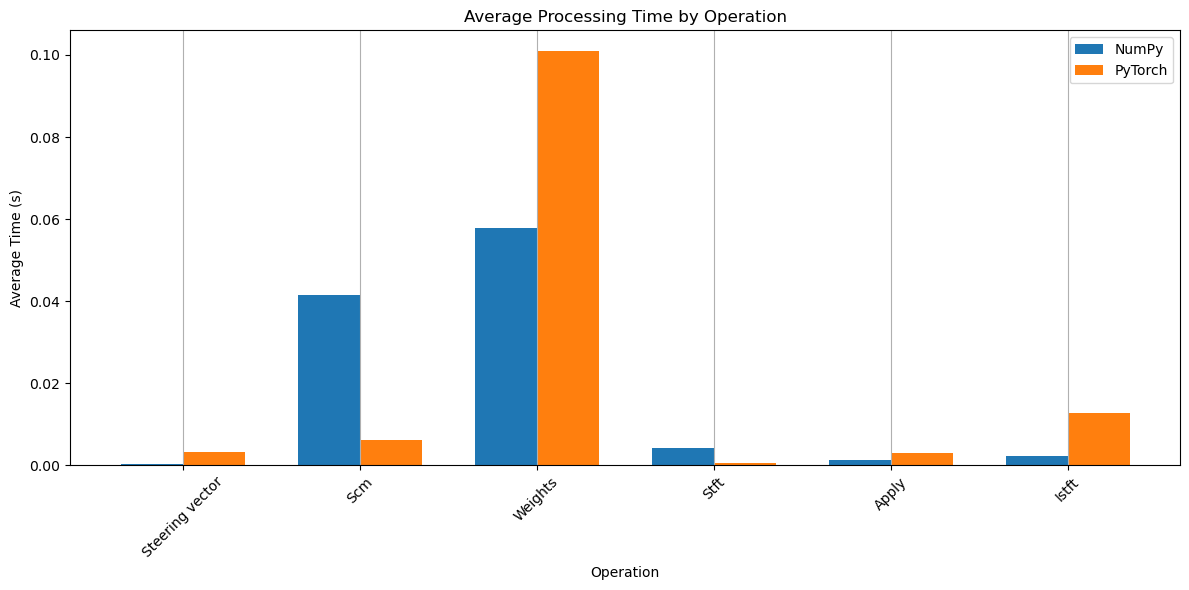

In [14]:
# Plot timing comparison across angles
plt.figure(figsize=(14, 8))

# Plot total processing time comparison
plt.subplot(2, 1, 1)
x = np.arange(len(angles))
width = 0.35

np_times = [all_results[angle]['timing_results']['numpy']['total'] for angle in angles]
pt_times = [all_results[angle]['timing_results']['pytorch']['total'] for angle in angles]

plt.bar(x - width/2, np_times, width, label='NumPy')
plt.bar(x + width/2, pt_times, width, label='PyTorch')

plt.xlabel('Look Direction (degrees)')
plt.ylabel('Total Processing Time (s)')
plt.title('Total Processing Time Comparison')
plt.xticks(x, angles)
plt.legend()
plt.grid(axis='y')

# Plot speedup across angles
plt.subplot(2, 1, 2)
plt.plot(angles, speedups, 'o-', color='purple')
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7)
plt.text(angles[0], 1.05, 'No speedup (1x)', color='r', ha='left')

plt.xlabel('Look Direction (degrees)')
plt.ylabel('Speedup Factor (NumPy time / PyTorch time)')
plt.title('PyTorch Speedup vs NumPy')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "timing_comparison.png"))
plt.show()

# Plot per-operation timing comparison (average across all angles)
operations = ['steering_vector', 'scm', 'weights', 'stft', 'apply', 'istft']
np_avg_times = [np.mean([all_results[angle]['timing_results']['numpy'][op] for angle in angles]) for op in operations]
pt_avg_times = [np.mean([all_results[angle]['timing_results']['pytorch'][op] for angle in angles]) for op in operations]

plt.figure(figsize=(12, 6))
x = np.arange(len(operations))
width = 0.35

plt.bar(x - width/2, np_avg_times, width, label='NumPy')
plt.bar(x + width/2, pt_avg_times, width, label='PyTorch')

plt.xlabel('Operation')
plt.ylabel('Average Time (s)')
plt.title('Average Processing Time by Operation')
plt.xticks(x, [op.replace('_', ' ').capitalize() for op in operations], rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "operation_timing_comparison.png"))
plt.show()

## 8. Conclusion

In [15]:
print("\n" + "="*80)
print("CONCLUSION")
print("="*80)

print(f"\nThe NumPy and PyTorch implementations show high agreement across all tested look directions:")
print(f"- Average RMSE between outputs: {avg_rmse:.2e}")
print(f"- Average Power Ratio: {avg_power_ratio:.2f} dB")

if avg_speedup > 1.0:
    print(f"\nOn average, the PyTorch implementation is {avg_speedup:.2f}x faster than NumPy.")
    fastest_op = operations[np.argmax([np_avg_times[i]/pt_avg_times[i] for i in range(len(operations))])]
    print(f"The operation with the largest speedup is '{fastest_op}'.")
else:
    print(f"\nOn average, the NumPy implementation is {1/avg_speedup:.2f}x faster than PyTorch.")
    
print("\nAll comparison visualizations have been saved to the '{}' directory.".format(OUTPUT_DIR))


CONCLUSION

The NumPy and PyTorch implementations show high agreement across all tested look directions:
- Average RMSE between outputs: nan
- Average Power Ratio: nan dB

On average, the NumPy implementation is 1.11x faster than PyTorch.

All comparison visualizations have been saved to the 'comparison_outputs' directory.
